# Chapter 16 - Exercises

In [1]:
library(tidyverse)
library(bayesrules)
library(bayesplot)
library(rstan)
library(rstanarm)
library(broom.mixed)
library(tidybayes)
library(forcats)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is bayesplot version 1.10.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: StanHeaders

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recomp

## Exercise 16.6

In [2]:
big_word_club <- big_word_club %>% 
  filter(treat == 1) %>% 
  select(school_id, score_pct_change) %>% 
  na.omit()

head( big_word_club )

school_id score_pct_change
1 2         -8.823529       
2 2         14.285714       
3 2         17.857143       
4 2          6.666667       
5 2         12.500000       
7 2         23.076923

## a)

In [3]:
big_word_club %>% 
    distinct( school_id ) %>% 
    nrow()

[1] 26

26 schools.

### b)

In [4]:
big_word_club %>% 
    group_by( school_id ) %>% 
    summarize( size=n() ) %>% 
    arrange( size ) %>% 
    filter(row_number()==1 | row_number()==n())

school_id size
1 2         12  
2 10        17

Each school has between 12-17 students in the project.

### c)

In [5]:
# reorder school_ids
big_word_club <- big_word_club  %>% 
    mutate( school_id = fct_reorder( school_id, score_pct_change, .fun='mean' ) )

school_changes <- big_word_club %>% 
    group_by( school_id ) %>% 
    summarize( mean_pct_change=mean(score_pct_change) )

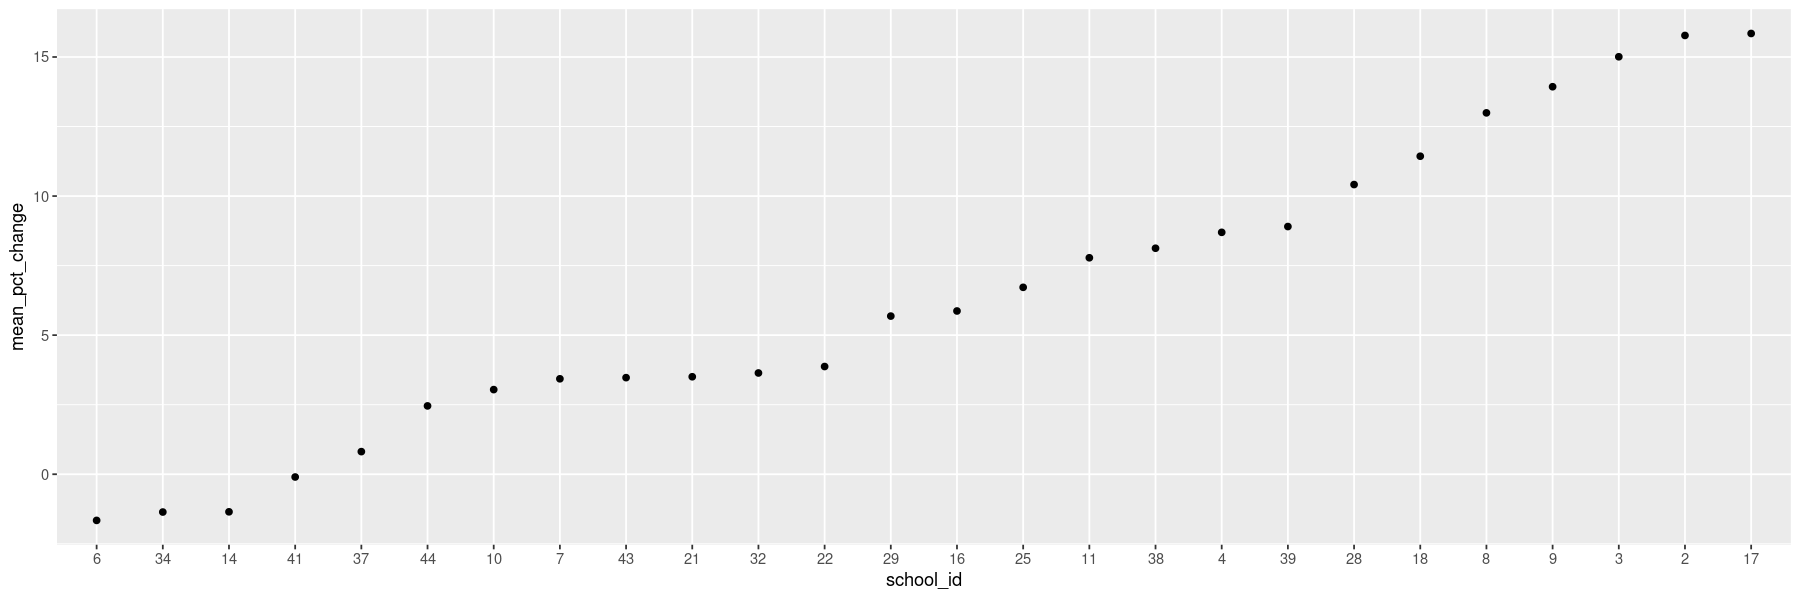

In [6]:
options(repr.plot.width=15, repr.plot.height=5)
ggplot( school_changes %>% arrange( mean_pct_change ), aes( x=school_id, y=mean_pct_change ) ) + geom_point()

School 6 has the lowest change, school 17 the highest.

### d)

Density plot:

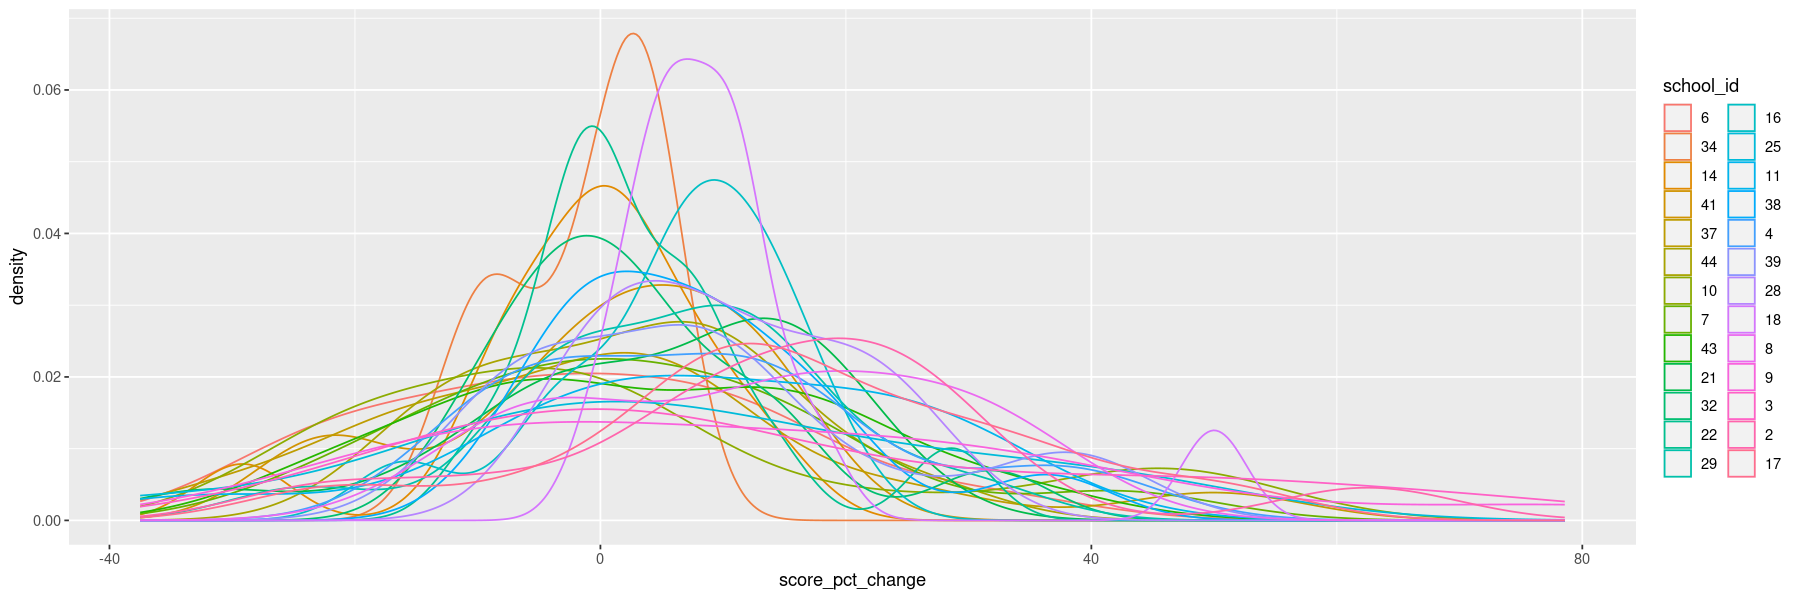

In [7]:
ggplot( big_word_club ) + geom_density( aes(x=score_pct_change, color=school_id) )

Box plot:

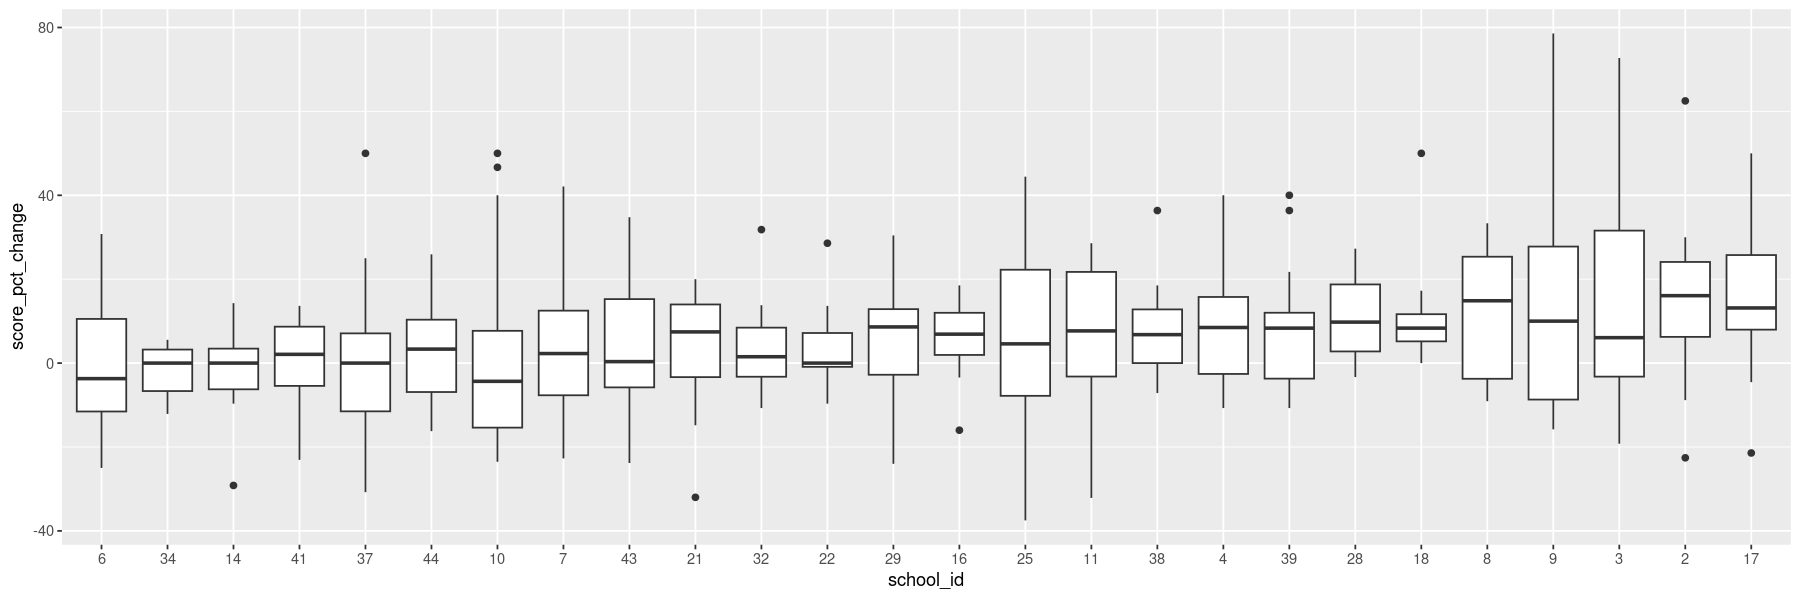

In [8]:
ggplot( big_word_club ) + geom_boxplot( aes(y=score_pct_change, x=school_id) )

It appears that the variability of students within a school (within-group variability) is quite large and almost as large as the between-group variability.

## Exercise 16.7

### a)

Not all possible schools were in the program. We might want to predict percent changes for other schools not yet in the dataset, therefore school_id should be a grouping variable. Moreover, there might be better and worse schools and which school a student is enrolled in might be an important factor. Complete pooling would ignore different school-level performances and predict a mean percent change for all students with a broad variance. In contrast, no pooling would only focus on the individual schools and overfit to them, even if they contributed only a small number of participants.

### b) 

$\mu$: global average of percent change, $\mu_j$: school average of percent change for school $j$.

### c)

$\sigma_y$: standard deviation on percent changes on school-level (within-group variance), $\sigma_\mu$: standard deviation on the different school averages.

### Exercise 16.8

### a)

In [9]:
big_words_hierarchical <- stan_glmer(
  score_pct_change ~ (1 | school_id), 
  data = big_word_club, family = gaussian,
  prior_intercept = normal(0, 1, autoscale = TRUE),
  prior_aux = exponential(1, autoscale = TRUE),
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.31066 seconds (Warm-up)
Chain 1:                1.94236 seconds (Sampling)
Chain 1:      

### b)

MCMC diagnostics:

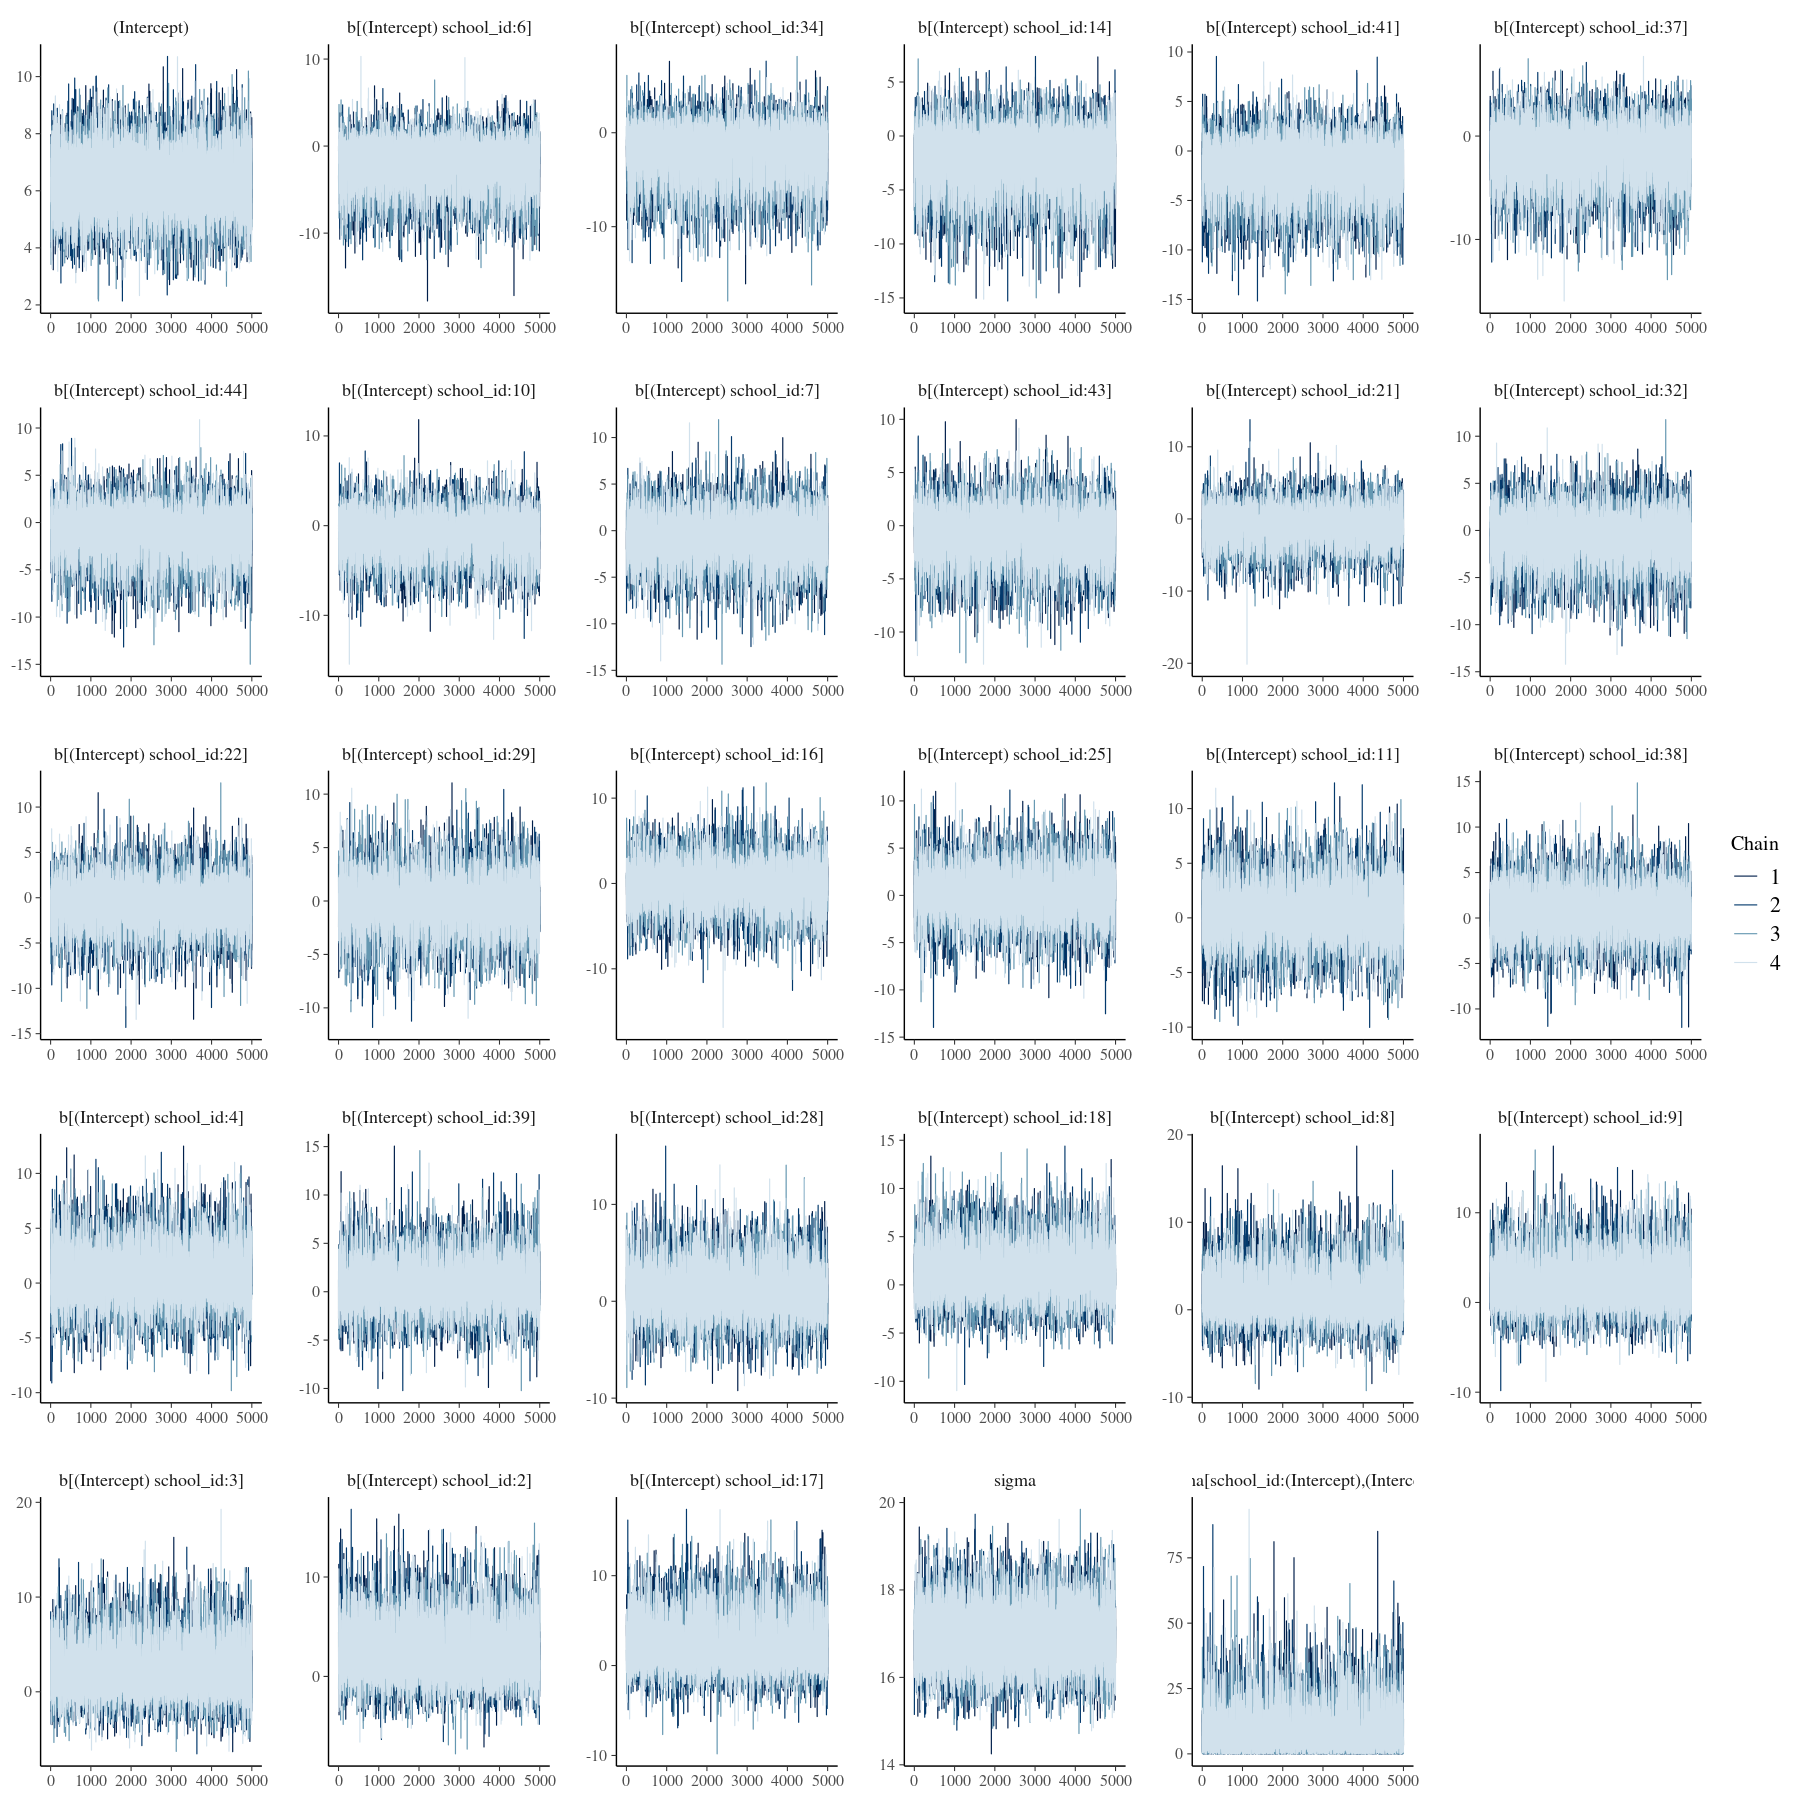

Warning message:
“The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the bayesplot package.
  Please report the issue at <https://github.com/stan-dev/bayesplot/issues/>.”


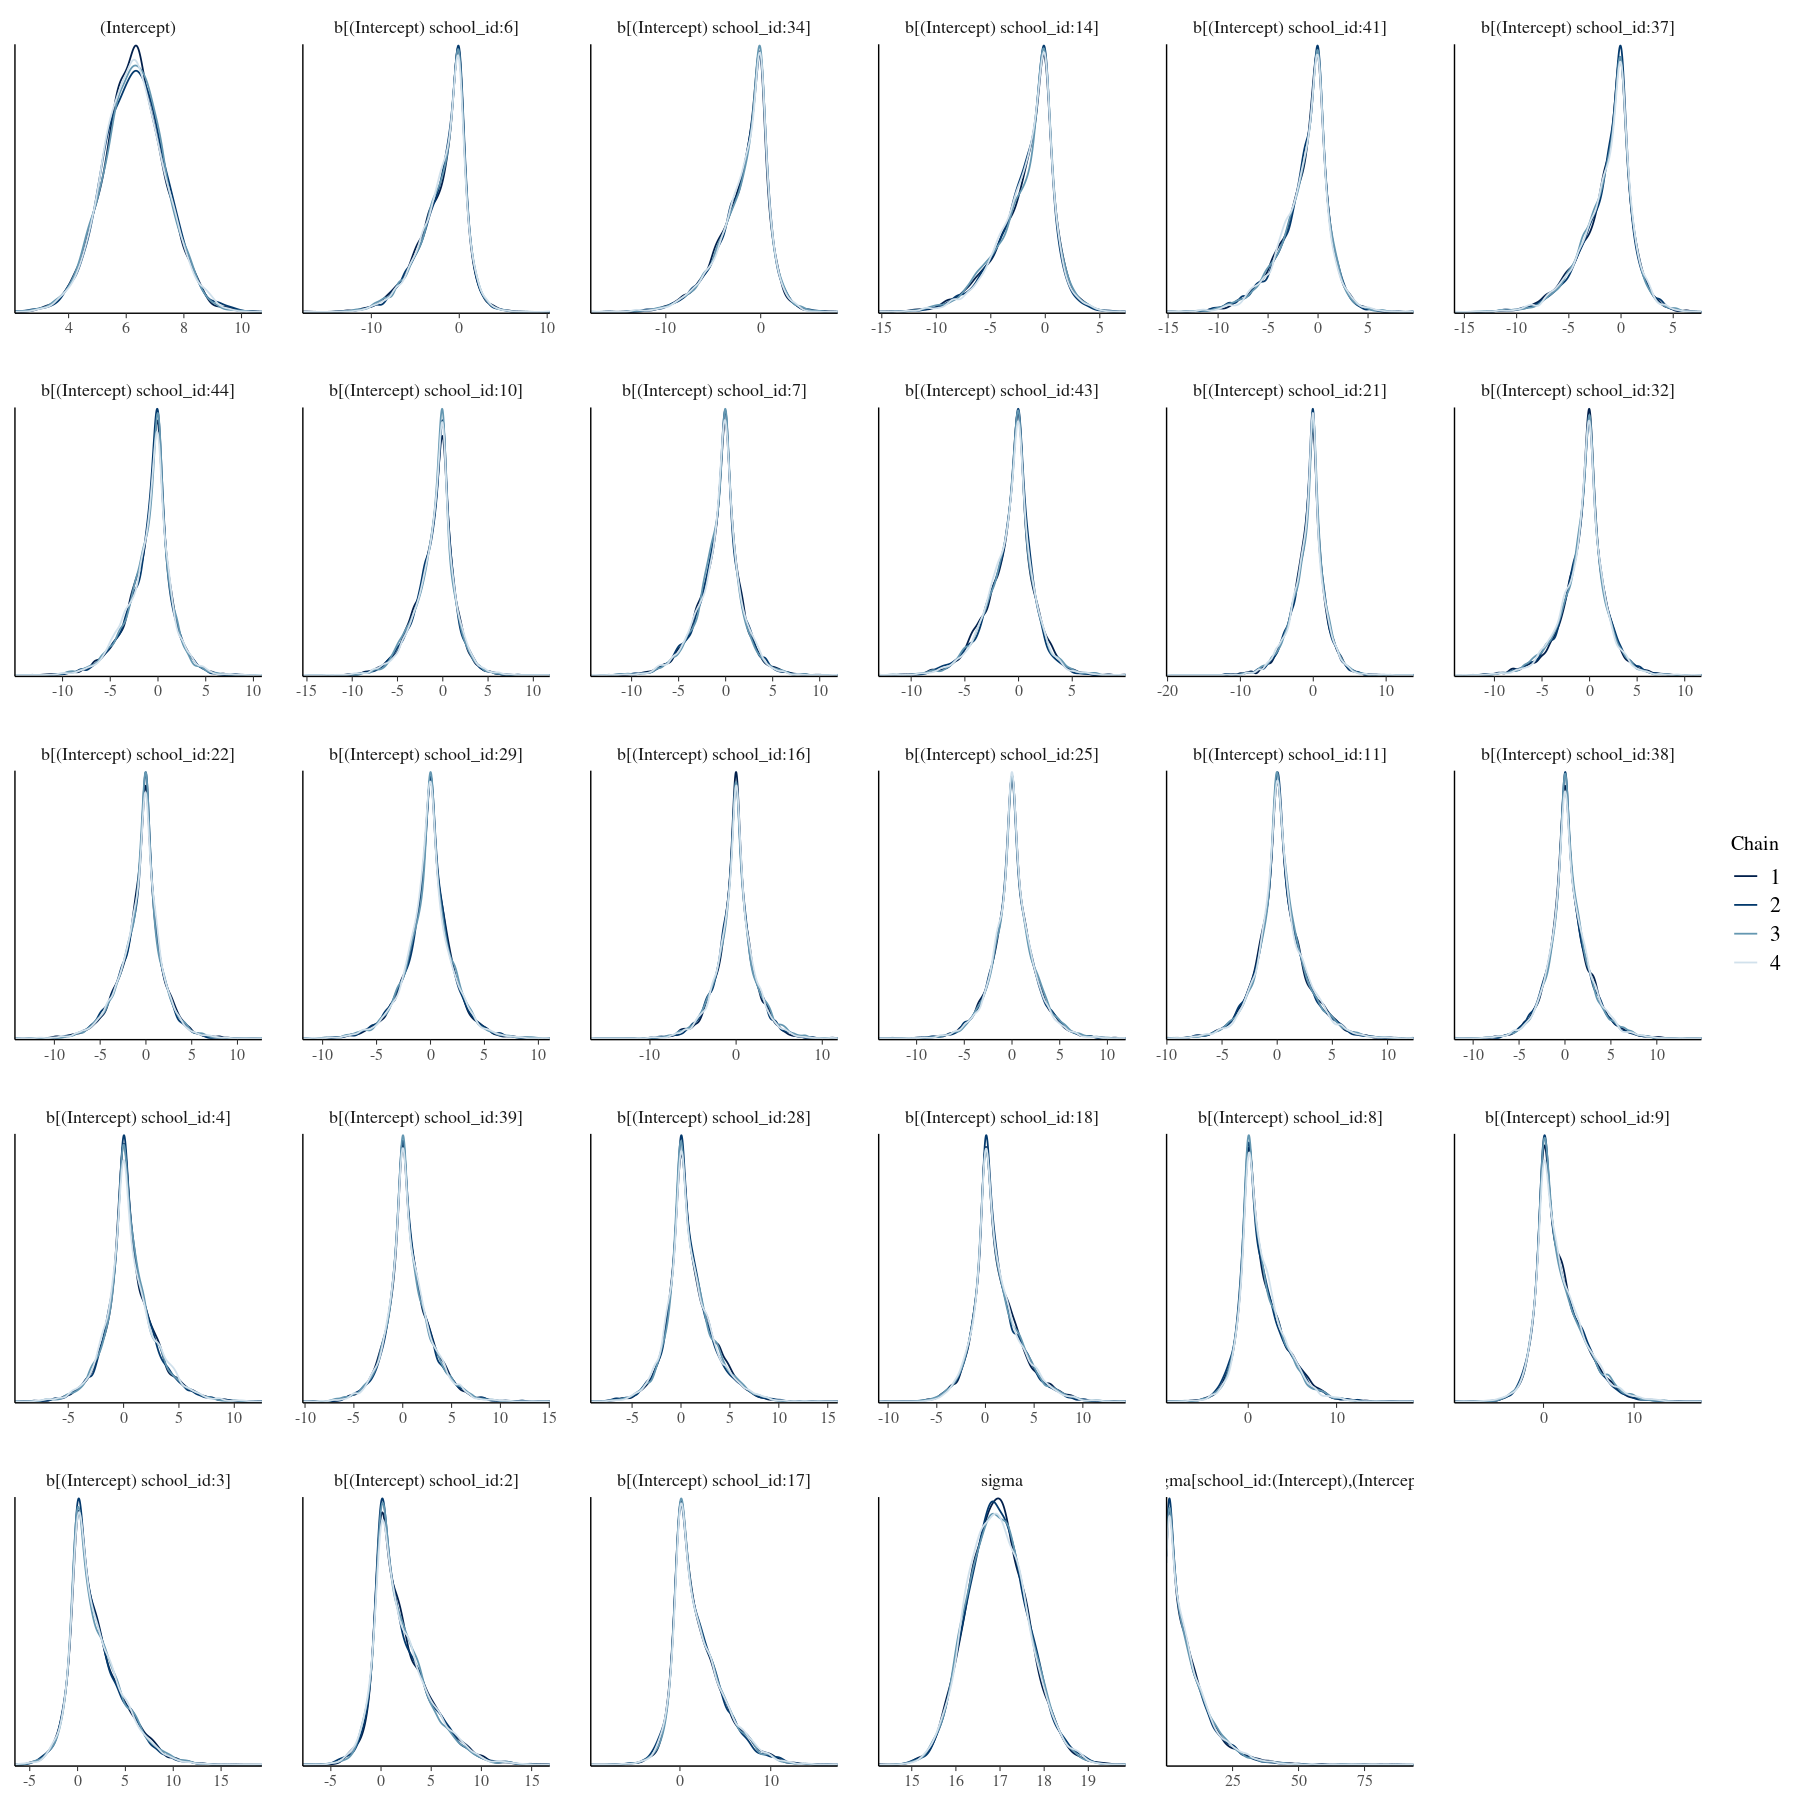

(Intercept) 
                                 0.77660 
              b[(Intercept) school_id:6] 
                                 0.62275 
             b[(Intercept) school_id:34] 
                                 0.64765 
             b[(Intercept) school_id:14] 
                                 0.67435 
             b[(Intercept) school_id:41] 
                                 0.81250 
             b[(Intercept) school_id:37] 
                                 0.78965 
             b[(Intercept) school_id:44] 
                                 0.99500 
             b[(Intercept) school_id:10] 
                                 0.97345 
              b[(Intercept) school_id:7] 
                                 1.11280 
             b[(Intercept) school_id:43] 
                                 0.98760 
             b[(Intercept) school_id:21] 
                                 1.10075 
             b[(Intercept) school_id:32] 
                                 1.06120 
             b[(Intercept) school_id:22] 
                                 1.16885 
             b[(Intercept) school_id:29] 
                                 1.30355 
             b[(Intercept) school_id:16] 
                                 1.24895 
             b[(Intercept) school_id:25] 
                                 1.24195 
             b[(Intercept) school_id:11] 
                                 1.25010 
             b[(Intercept) school_id:38] 
                                 1.21305 
              b[(Intercept) school_id:4] 
                                 1.14410 
             b[(Intercept) school_id:39] 
                                 1.10055 
             b[(Intercept) school_id:28] 
                                 0.98890 
             b[(Intercept) school_id:18] 
                                 0.88975 
              b[(Intercept) school_id:8] 
                                 0.74145 
              b[(Intercept) school_id:9] 
                                 0.70590 
              b[(Intercept) school_id:3] 
                                 0.65550 
              b[(Intercept) school_id:2] 
                                 0.62600 
             b[(Intercept) school_id:17] 
                                 0.59995 
                                   sigma 
                                 1.06340 
Sigma[school_id:(Intercept),(Intercept)] 
                                 0.36505

(Intercept) 
                               0.9999760 
              b[(Intercept) school_id:6] 
                               0.9999884 
             b[(Intercept) school_id:34] 
                               0.9999260 
             b[(Intercept) school_id:14] 
                               0.9999020 
             b[(Intercept) school_id:41] 
                               0.9998495 
             b[(Intercept) school_id:37] 
                               0.9999368 
             b[(Intercept) school_id:44] 
                               0.9999147 
             b[(Intercept) school_id:10] 
                               0.9999079 
              b[(Intercept) school_id:7] 
                               0.9998362 
             b[(Intercept) school_id:43] 
                               0.9999697 
             b[(Intercept) school_id:21] 
                               0.9999895 
             b[(Intercept) school_id:32] 
                               1.0000107 
             b[(Intercept) school_id:22] 
                               0.9999254 
             b[(Intercept) school_id:29] 
                               1.0000545 
             b[(Intercept) school_id:16] 
                               0.9999641 
             b[(Intercept) school_id:25] 
                               1.0000702 
             b[(Intercept) school_id:11] 
                               1.0000969 
             b[(Intercept) school_id:38] 
                               0.9999336 
              b[(Intercept) school_id:4] 
                               0.9998863 
             b[(Intercept) school_id:39] 
                               0.9998744 
             b[(Intercept) school_id:28] 
                               1.0000258 
             b[(Intercept) school_id:18] 
                               1.0000266 
              b[(Intercept) school_id:8] 
                               1.0000867 
              b[(Intercept) school_id:9] 
                               1.0000106 
              b[(Intercept) school_id:3] 
                               0.9999397 
              b[(Intercept) school_id:2] 
                               1.0000568 
             b[(Intercept) school_id:17] 
                               1.0002561 
                                   sigma 
                               0.9998773 
Sigma[school_id:(Intercept),(Intercept)] 
                               1.0001127

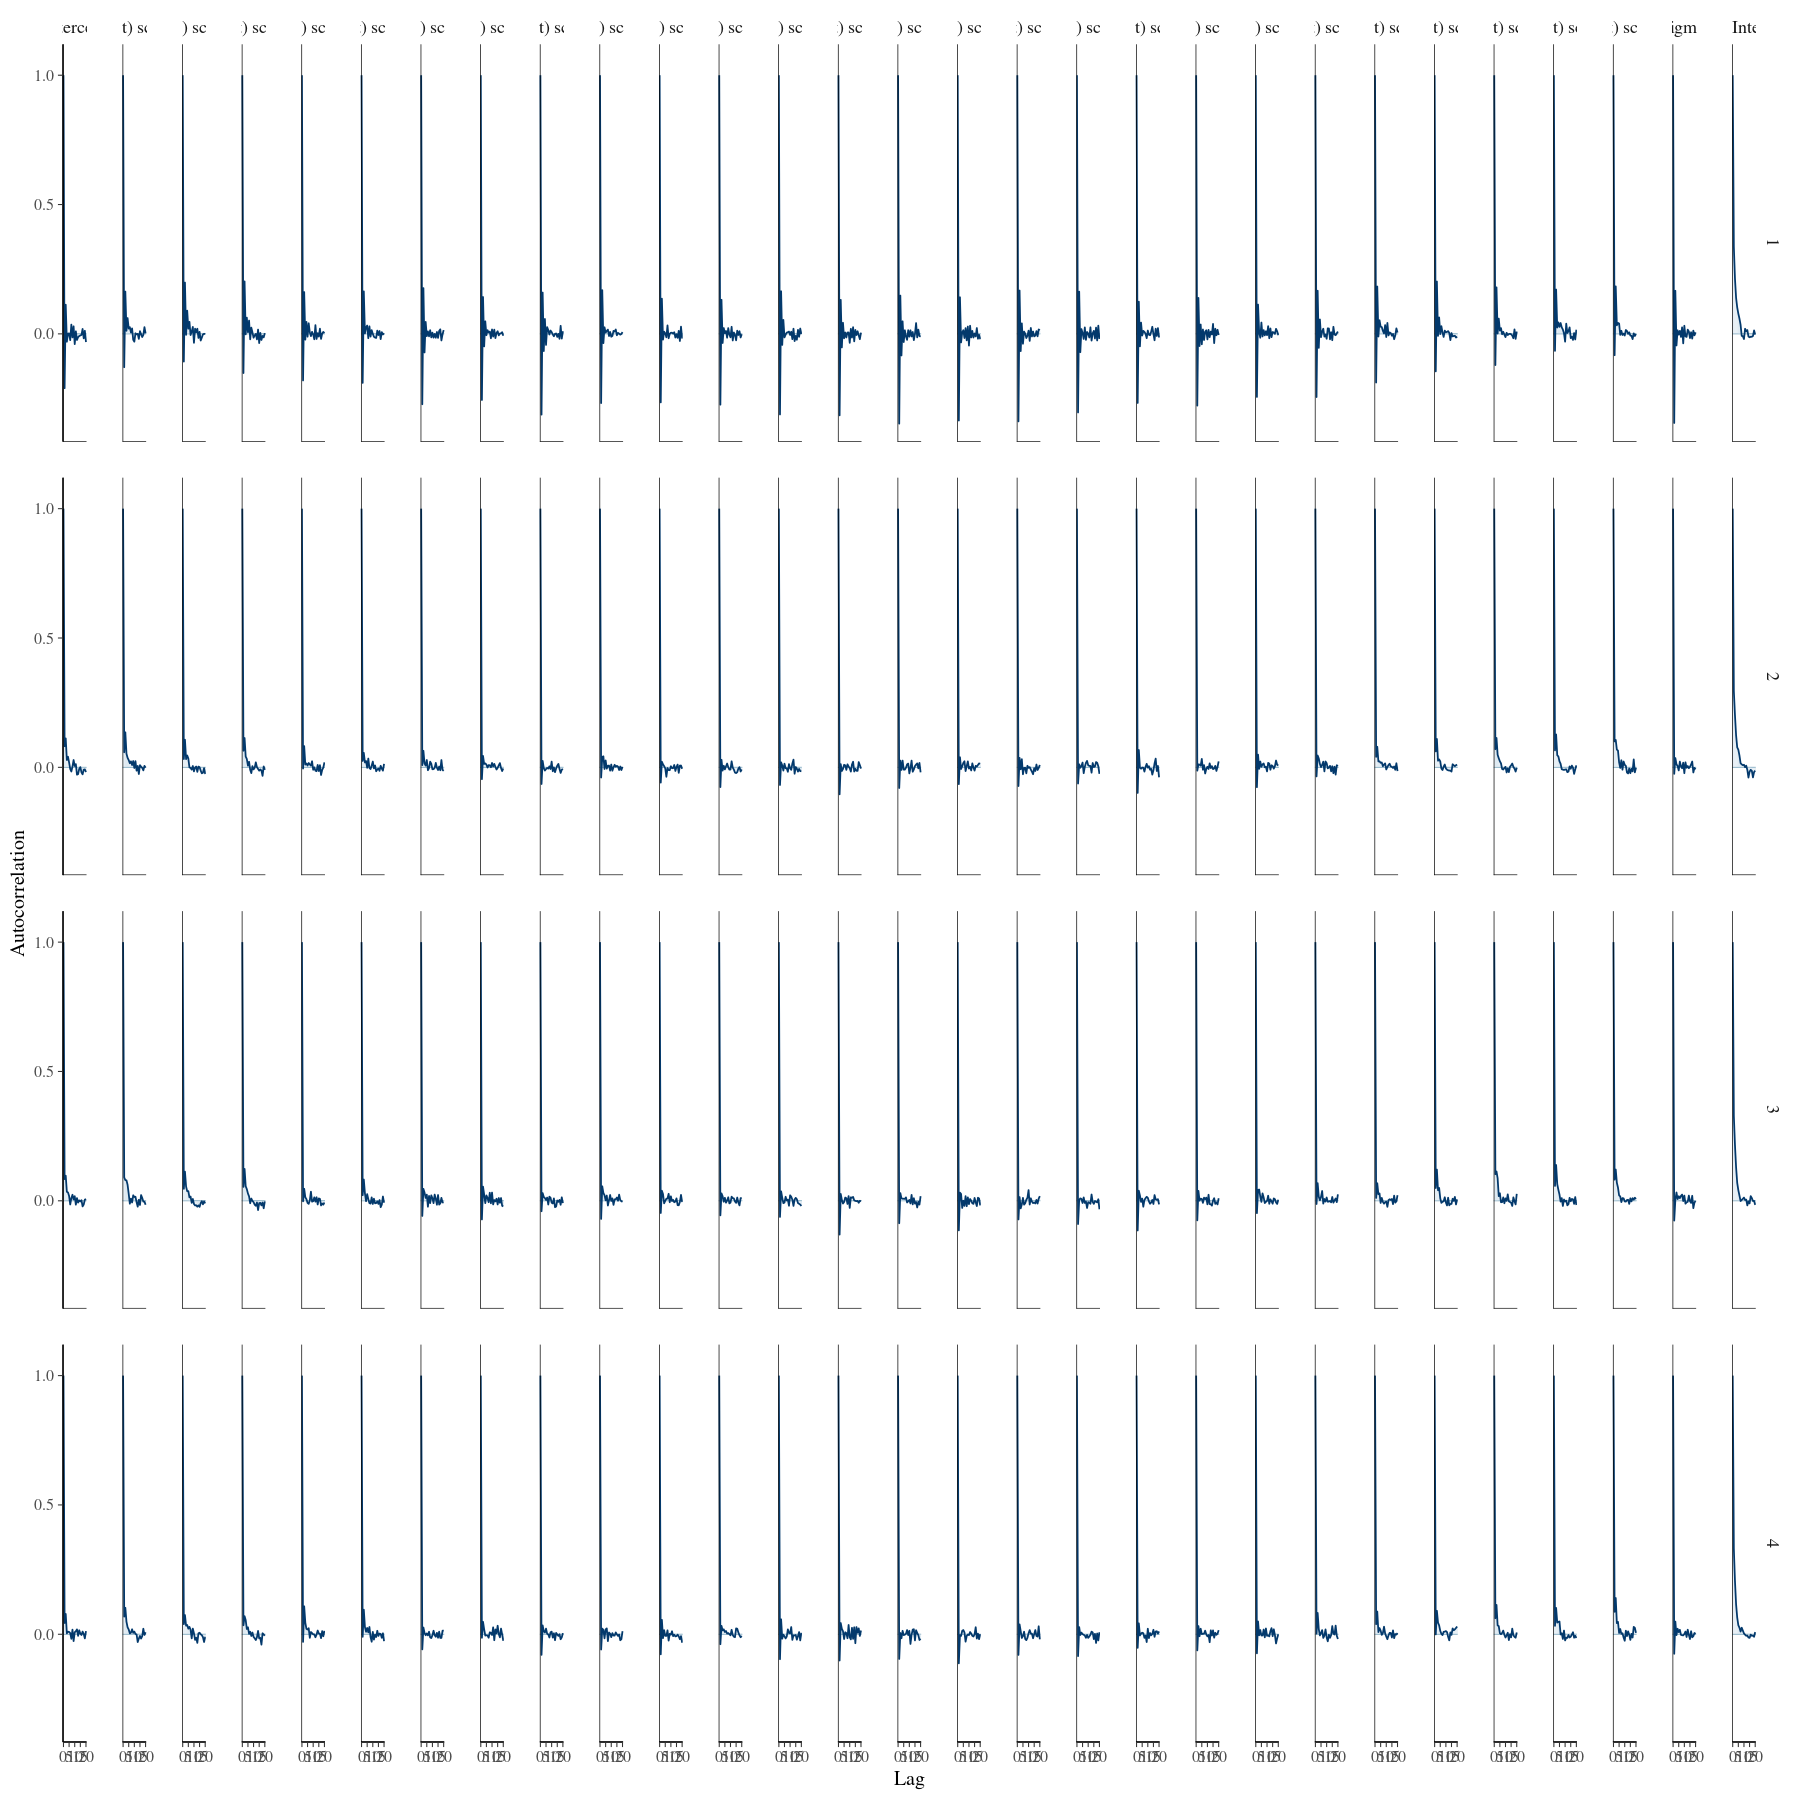

In [10]:
options(repr.plot.width=15, repr.plot.height=15)
mcmc_trace(big_words_hierarchical)
mcmc_dens_overlay(big_words_hierarchical)
mcmc_acf(big_words_hierarchical)
neff_ratio(big_words_hierarchical)
rhat(big_words_hierarchical)

Looks converged and mixing is reasonably fast.

### c)

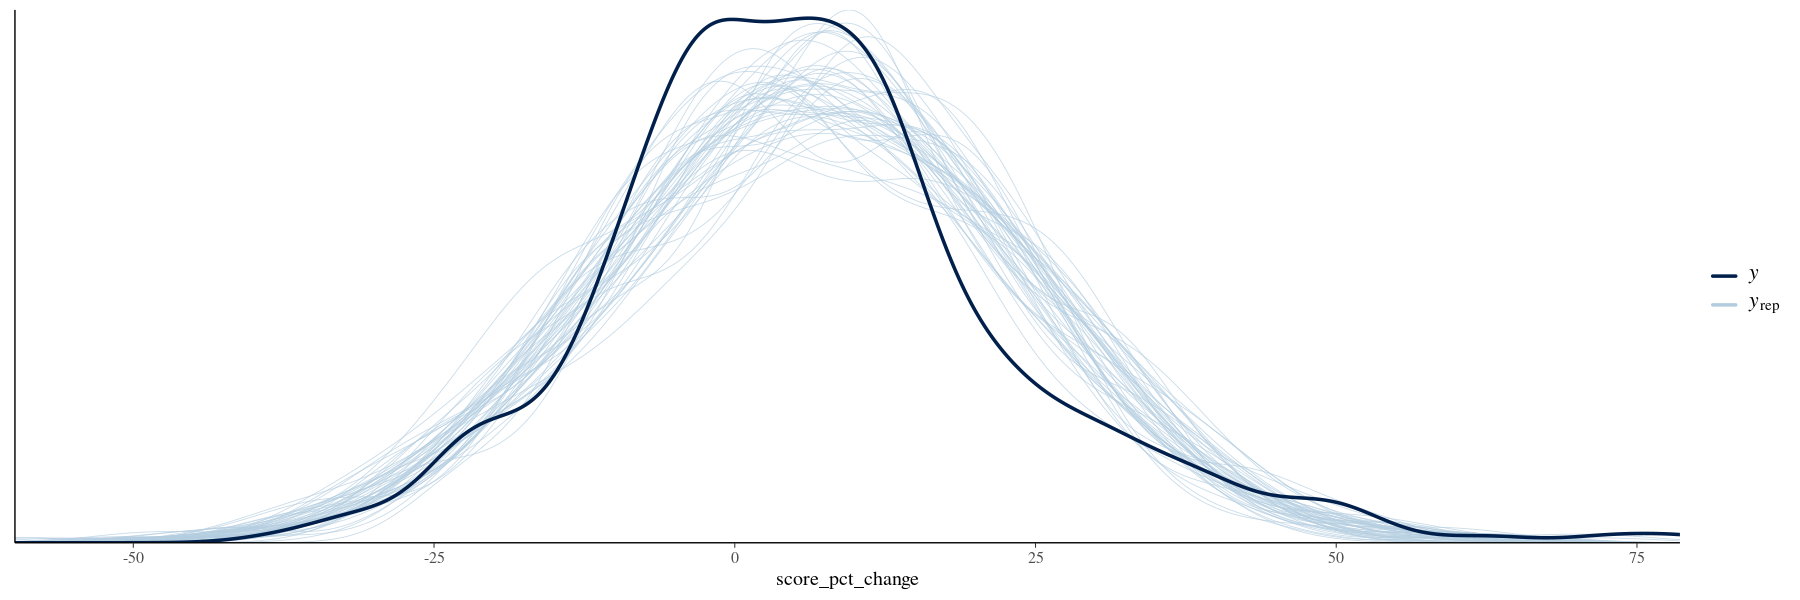

In [11]:
options(repr.plot.width=15, repr.plot.height=5)
pp_check(big_words_hierarchical) + xlab("score_pct_change")

Looks more or less ok, the data distribution is not perfectly Gaussian, but approximately.

## Exercise 16.9

### a)

In [12]:
tidy(big_words_hierarchical, effects = "fixed", conf.int = TRUE, conf.level = 0.95)

term        estimate std.error conf.low conf.high
1 (Intercept) 6.279869 1.05056   4.167856 8.415107

The average percent change per school is somewhere between 4.2 and 8.4% with a probability of 95%.

### b)

Yes, the 95% credible interval does not include zero. Of course it has to be checked with a control group whether the program is the causal factor.

### c)

In [13]:
sigma_table <- tidy(big_words_hierarchical, effects = "ran_pars")
sigma_table

term                     group     estimate 
1 sd_(Intercept).school_id school_id  2.841094
2 sd_Observation.Residual  Residual  16.944405

$\sigma_y > \sigma_\mu$

In [14]:
sigma_mu <- sigma_table$estimate[[1]]
sigma_y <- sigma_table$estimate[[2]]

Part explained by within-group variation:

In [15]:
sigma_y^2 / (sigma_mu^2 + sigma_y^2)

[1] 0.972655

Part explained by between-group variation:

In [16]:
sigma_mu^2 / (sigma_mu^2 + sigma_y^2)

[1] 0.02734497

Almost all of the variance can be explained by the large variances within the groups, therefore the structuring into groups does not help significantly to reduce the overall variance. It appears that there are in general not really significant differences between different schools.

##  Exercise 16.10

Confidence intervals:

In [17]:
school_summary <- tidy(big_words_hierarchical, effects = "ran_vals", conf.int = TRUE, conf.level = 0.80)
head( school_summary )

level group     term        estimate   std.error conf.low  conf.high
1 6     school_id (Intercept) -1.1573179 2.057899  -5.365002 0.7743921
2 34    school_id (Intercept) -1.1071884 2.028525  -5.281117 0.8561878
3 14    school_id (Intercept) -1.1017874 2.004915  -5.292467 0.8616252
4 41    school_id (Intercept) -0.8137951 1.865341  -4.708564 1.1790100
5 37    school_id (Intercept) -0.7818682 1.831196  -4.578975 1.1599582
6 44    school_id (Intercept) -0.4706073 1.710459  -3.922703 1.5944033

Extract values directly from posterior simulation:

In [18]:
school_chains <- big_words_hierarchical %>%
  spread_draws(`(Intercept)`, b[,school_id]) %>% 
  mutate(mu_j = `(Intercept)` + b) 

head( school_chains )

.chain .iteration .draw (Intercept) school_id    b          mu_j    
1 1      1          1     4.387914    school_id:10 -0.3475687 4.040345
2 1      1          1     4.387914    school_id:11  0.9049150 5.292829
3 1      1          1     4.387914    school_id:14  0.1307815 4.518695
4 1      1          1     4.387914    school_id:16 -1.3284611 3.059453
5 1      1          1     4.387914    school_id:17  4.5041983 8.892112
6 1      1          1     4.387914    school_id:18  1.2748540 5.662768

In [19]:
school_summary_scaled <- school_chains %>% 
  select(-`(Intercept)`, -b) %>% 
  mean_qi(.width = 0.80) %>% 
  mutate(school_id = fct_reorder(school_id, mu_j))

head( school_summary_scaled )

school_id    mu_j     .lower    .upper    .width .point .interval
1 school_id:10 5.437570 2.4592220  8.080118 0.8    mean   qi       
2 school_id:11 6.619242 3.7894297  9.640071 0.8    mean   qi       
3 school_id:14 4.574334 0.8913668  7.517379 0.8    mean   qi       
4 school_id:16 6.191805 3.3454124  9.060449 0.8    mean   qi       
5 school_id:17 8.272652 5.2266488 12.211449 0.8    mean   qi       
6 school_id:18 7.357190 4.5755219 10.684811 0.8    mean   qi

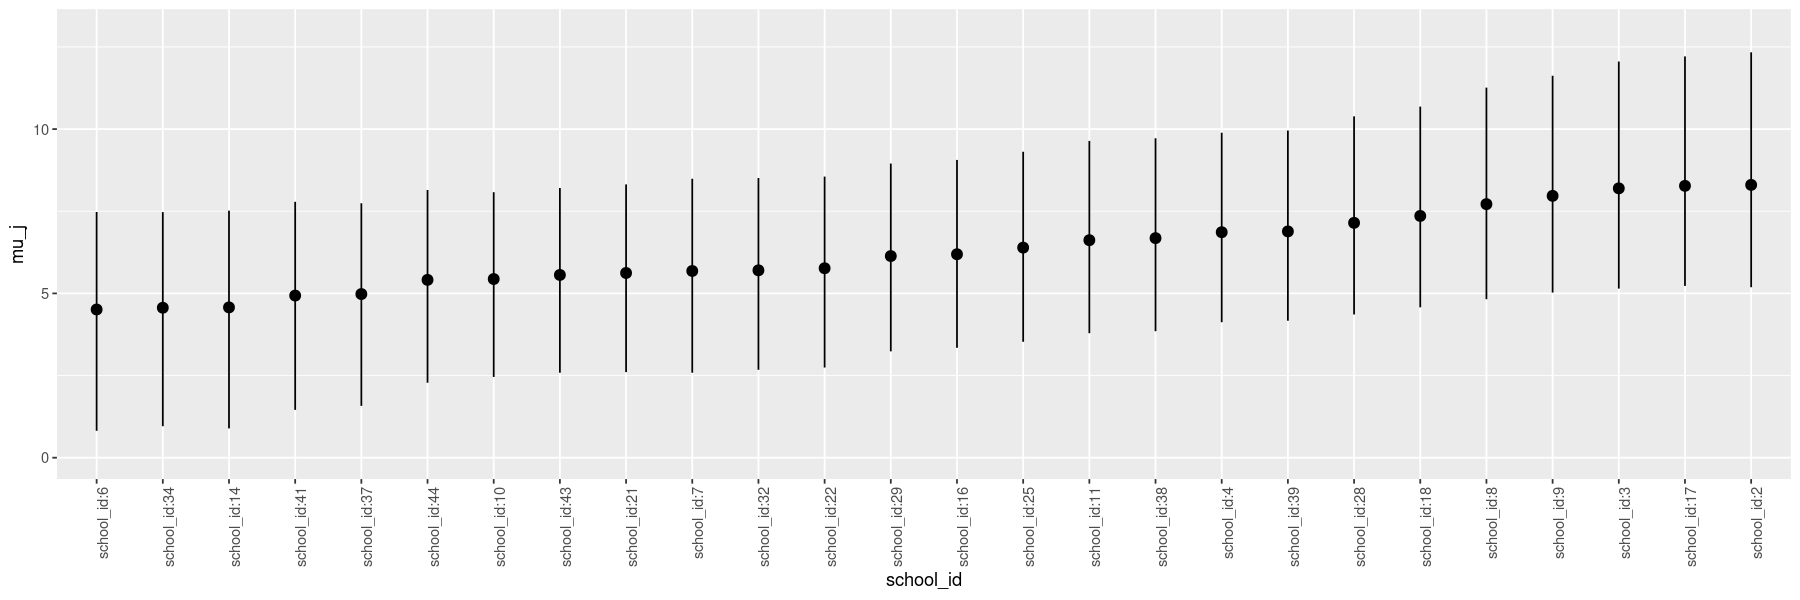

In [20]:
ggplot(school_summary_scaled, 
       aes(x = school_id, y = mu_j, ymin = .lower, ymax = .upper)) +
  geom_pointrange() +
  xaxis_text(angle = 90, hjust = 1) +
  ylim(0, 13)

It is clearly visible here that the variability within schools is large and probably because of the lower number of students it is hard to constrain the values for $\mu_j$.

### b)

In [21]:
school_chains %>% 
    filter( school_id=="school_id:10") %>% 
    summarize( conf.low=quantile(mu_j, 0.1), conf.high=quantile(mu_j, 0.9))

school_id    conf.low conf.high
1 school_id:10 2.459222 8.080118

$\mu_{10}$ is somewhere between 2.5 and 8.1% with a probability of 80%.

### c)

$H_0$: On average, vocabulary scores at School 10 improved by $\leq 5\%$.

$H_1$: On average, vocabulary scores at School 10 improved by $> 5\%$.

In [22]:
school_chains %>% 
    filter( school_id=="school_id:10") %>% 
    summarize( pH0=mean(mu_j<=5), pH1=mean(mu_j>5), odds=pH1/pH0 )

school_id    pH0     pH1     odds    
1 school_id:10 0.38115 0.61885 1.623639

The odds are 1.6:1 that on average vocabulary scores at School 10 improved by $> 5\%$. I would not consider this as very overwhelming evidence.

## Exercise 16.11

### a)

School 6:

In [23]:
big_words_hierarchical_df <- data.frame( big_words_hierarchical )
school6_chains <- big_words_hierarchical_df %>% 
    rename(b = b..Intercept..school_id.6.) %>% 
    select(X.Intercept., b, sigma ) %>% 
    mutate( mu_6 = X.Intercept. + b ) %>% 
    mutate( y_new_6 = rnorm(nrow(big_words_hierarchical_df), mean=mu_6, sd=sigma) )

head( school6_chains$y_new_6 )

[1]  8.514633 16.972645 15.545097  6.973322 15.602524 -5.228533

Bayes Prep School:

In [24]:
bayes_prep_chains <- big_words_hierarchical_df %>%
    mutate( sigma_mu = sqrt(Sigma.school_id..Intercept...Intercept..)) %>% 
    select( mu=X.Intercept., sigma_y=sigma, sigma_mu ) %>% 
    mutate( mu_new=rnorm(nrow(big_words_hierarchical_df), mean=mu, sd=sigma_mu) ) %>% 
    mutate( y_new=rnorm(nrow(big_words_hierarchical_df), mean=mu_new, sd=sigma_y) )

head( bayes_prep_chains$y_new )

[1]   6.620525  13.108726  19.815803  32.479747  -7.729993 -14.468783

### b)

In [25]:
school6_chains %>% 
  mean_qi(y_new_6, .width = 0.80)

y_new_6  .lower    .upper   .width .point .interval
1 4.572323 -17.18265 26.34574 0.8    mean   qi

In [26]:
bayes_prep_chains %>% 
  mean_qi(y_new, .width = 0.80)

y_new    .lower    .upper   .width .point .interval
1 6.422143 -15.49832 28.31004 0.8    mean   qi

The 80% credible intervals for the percent change of a new student are almost similar ([-17.7,26.1] for school 6 and [-15.7,28.4] for the new Bayes Prep school). This makes sense, because the knowledge about school 6 does not help much in reducing variability (as elaborated above - most of the data explained by within-group variation).

This are the standard deviations on group 6 and on the full dataset: they are practically similar

In [27]:
big_word_club %>% 
    filter( school_id==6 ) %>% 
    summarize( count=n(), mean=mean(score_pct_change), sd=sd(score_pct_change) )

count mean      sd      
1 13    -1.660463 16.31915

In [28]:
big_word_club %>% 
    summarize( count=n(), mean=mean(score_pct_change), sd=sd(score_pct_change) )

count mean     sd      
1 336   6.266634 17.08279

### c)

In [29]:
prediction_shortcut <- posterior_predict(
    big_words_hierarchical,
    newdata = data.frame(school_id = c("6", "17", "Bayes Prep"))
)

head( prediction_shortcut )

1          2         3         
[1,]  19.360207 28.410183  -2.117322
[2,] -14.678166 20.143041 -19.841212
[3,]  -9.707441 12.514682 -13.162466
[4,]   8.076675  1.585082  20.618833
[5,]  10.987653  4.382616   1.962025
[6,]  20.454708 14.510902  -3.756015

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


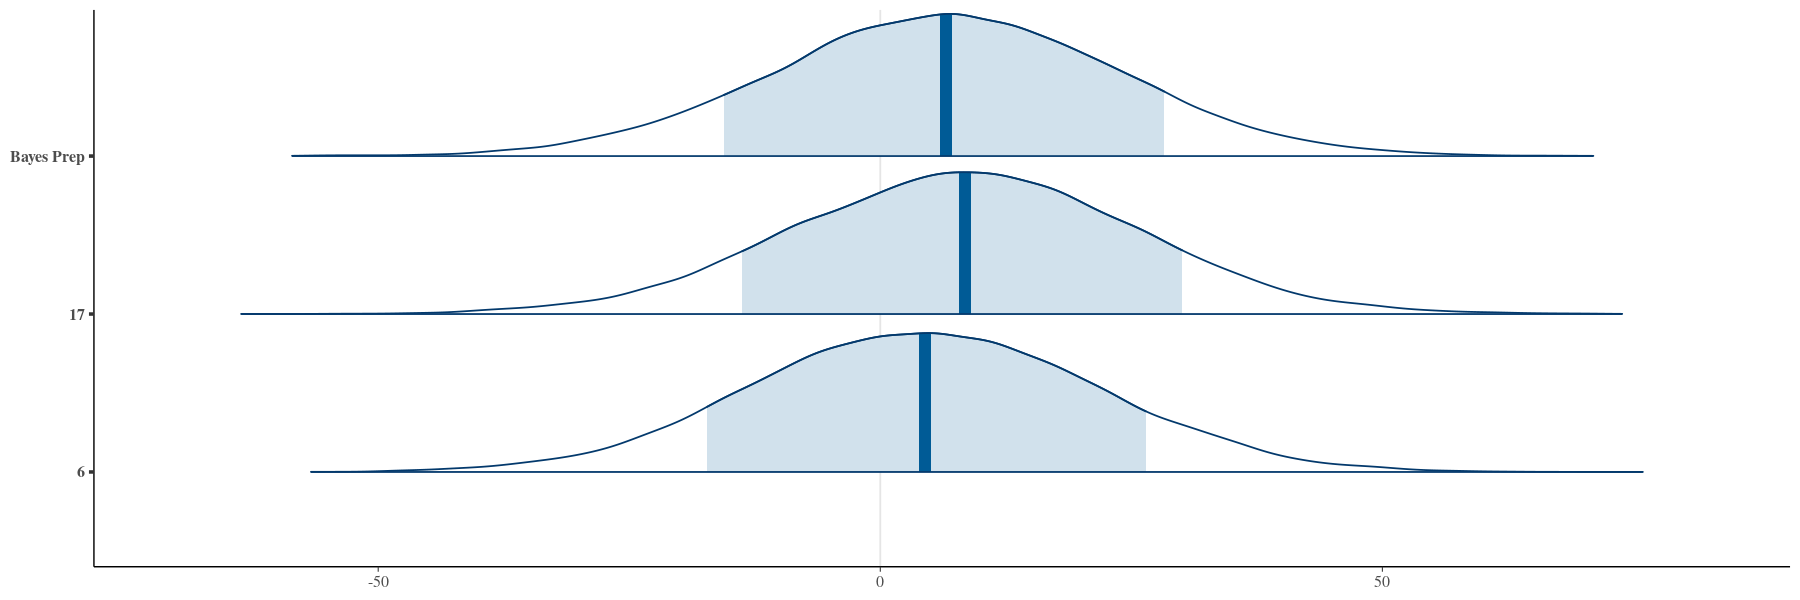

In [30]:
mcmc_areas(prediction_shortcut, prob = 0.8) + ggplot2::scale_y_discrete(labels = c("6", "17", "Bayes Prep"))

As already exlained in b), the intervals are almost similar and knowledge of the school id does not help in reducing the variance of the prediction.

### d)

In [31]:
school_means <- big_word_club %>% 
  group_by(school_id) %>% 
  summarize(count = n(), score_pct_change = mean(score_pct_change))
predictions_hierarchical <- posterior_predict(big_words_hierarchical, newdata = school_means)
head( predictions_hierarchical )

1          2          3          4          5          6         
[1,] -22.447283 -12.694384 -10.963307  40.647960 -40.792903   8.407682
[2,] -31.028076  36.476210   1.453358  14.039008  -6.798339   6.561587
[3,]  13.836933  -2.229947  10.743110 -13.796497   3.330382   3.318527
[4,]  -9.983929   1.181368 -22.183571  44.144067 -20.364714 -18.300576
[5,]   5.205300  17.341943  17.769310   8.285007   2.488671  14.100623
[6,]   9.302670 -24.551091  -6.215559  17.758556 -13.864474 -12.534279
     7           8         9           10          ⋯ 17        18        
[1,]  -3.5384421  4.778908 -10.6129207  18.3317621 ⋯ 13.527956 -16.776267
[2,]  35.4545970  3.052062  26.6956682 -20.6007675 ⋯ 10.297960  16.758950
[3,] -19.8119684 -4.347346  -0.8386608   2.8053554 ⋯  7.556056  10.312567
[4,]   0.1340036  4.872106   4.7380075   3.0431498 ⋯ -6.430184 -15.837449
[5,]  10.1758288 15.806692  -3.3906898  16.0745671 ⋯ 20.050589 -25.857926
[6,] -23.7340549 -2.332081 -19.3471753   0.4930224 ⋯ 23.660922  -7.557138
     19         20         21         22        23         24         25       
[1,]   2.975109   3.471869  1.3943626  7.217671  17.456370  26.841043  24.46671
[2,]  30.849420  17.612320 14.7292346  9.259797  11.315089 -16.907547 -25.17785
[3,]  -2.803082  42.657111 35.9015015  5.853133  30.246475   7.613583  15.32051
[4,]  28.287370   3.562904  9.3637781 41.098212 -20.966321  -1.682361  25.58807
[5,]  -1.400901 -13.101007 -0.3815121  7.504661   8.190641   4.846326  21.06306
[6,] -33.548563  -2.365188 10.2587884 18.491997 -19.256947  -5.772193  54.62187
     26       
[1,] 18.708679
[2,] -4.553267
[3,] 20.201743
[4,] 16.549521
[5,] 24.702188
[6,] 15.215701

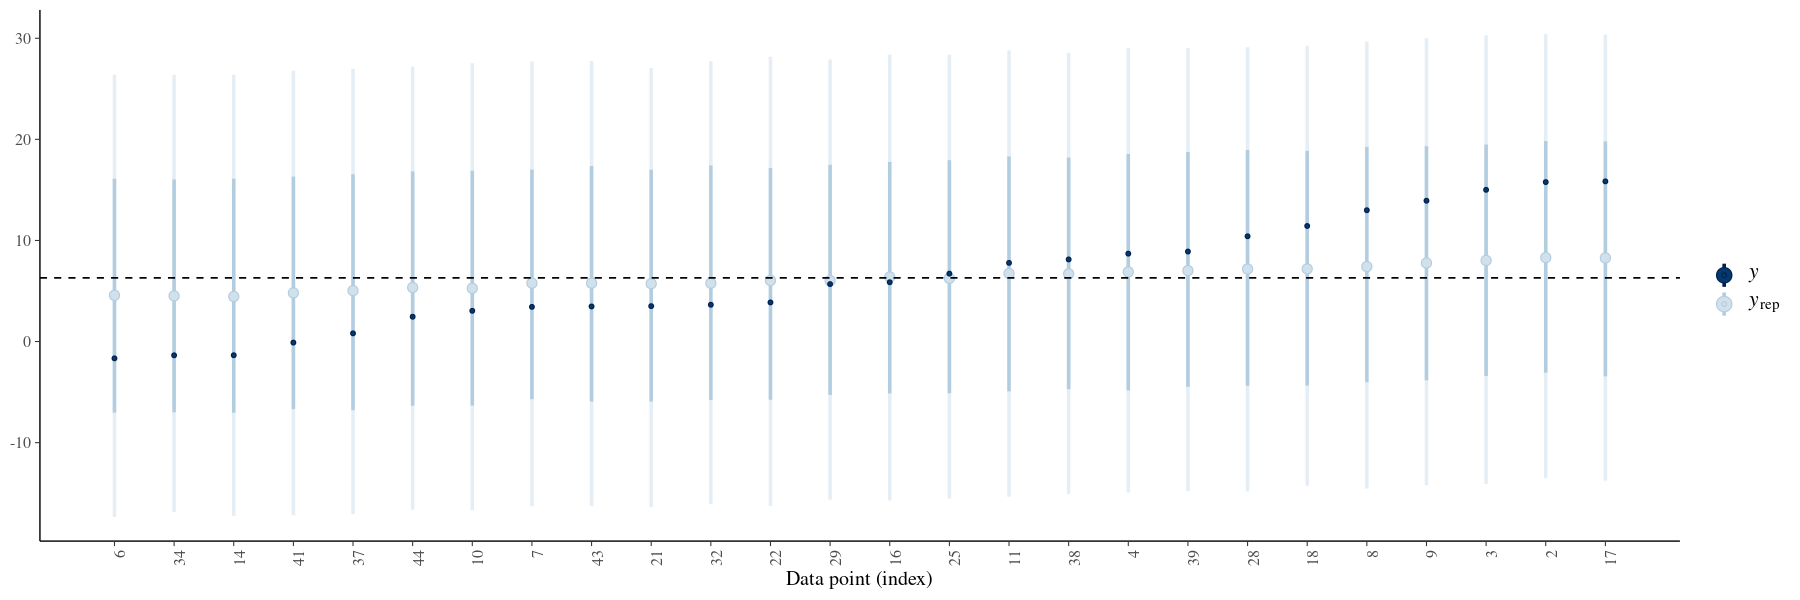

In [32]:
ppc_intervals(school_means$score_pct_change, yrep = predictions_hierarchical, prob_outer = 0.80) +
  ggplot2::scale_x_continuous(labels = school_means$school_id, breaks = 1:nrow(school_means)) +
  xaxis_text(angle = 90, hjust = 1) + 
  geom_hline(yintercept = 6.3, linetype = "dashed")

All prediction intervals are extremely similar, as before.

## Exercise 16.12

There is a lot of shrinkage in this analysis, all the posterior intervals are pulled towards the global mean. The posterior mean predictions with weakly-informed priors are roughly the weighted averages 

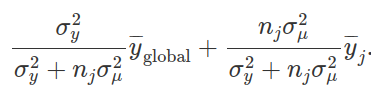

Since $\sigma_y^2 \gg \sigma_\mu^2$, the posterior means are pulled towards $\bar{y}_\text{global}$. This makes sense, in the light of the large within-group variation, we should not focus too much on individual schools.

## Exercise 16.13

### Exploratory Analysis

In [33]:
voices <- voices %>% 
    select( subject, pitch ) %>% 
    na.omit

head( voices )

subject pitch
1 A       229.7
2 A       237.3
3 A       236.8
4 A       251.0
5 A       267.0
6 A       266.0

In [34]:
voices %>% 
    group_by( subject ) %>% 
    summarize( experiments=n(), mean_pitch=mean(pitch), sd_pitch=sd(pitch) )

subject experiments mean_pitch sd_pitch
1 A       14          250.7357   29.37261
2 B       13          145.9769   41.47626
3 C       14          232.0357   39.27762
4 D       14          102.1786   12.46553
5 E       14          258.1857   31.35594
6 F       14          168.9786   21.04421

Density plot:

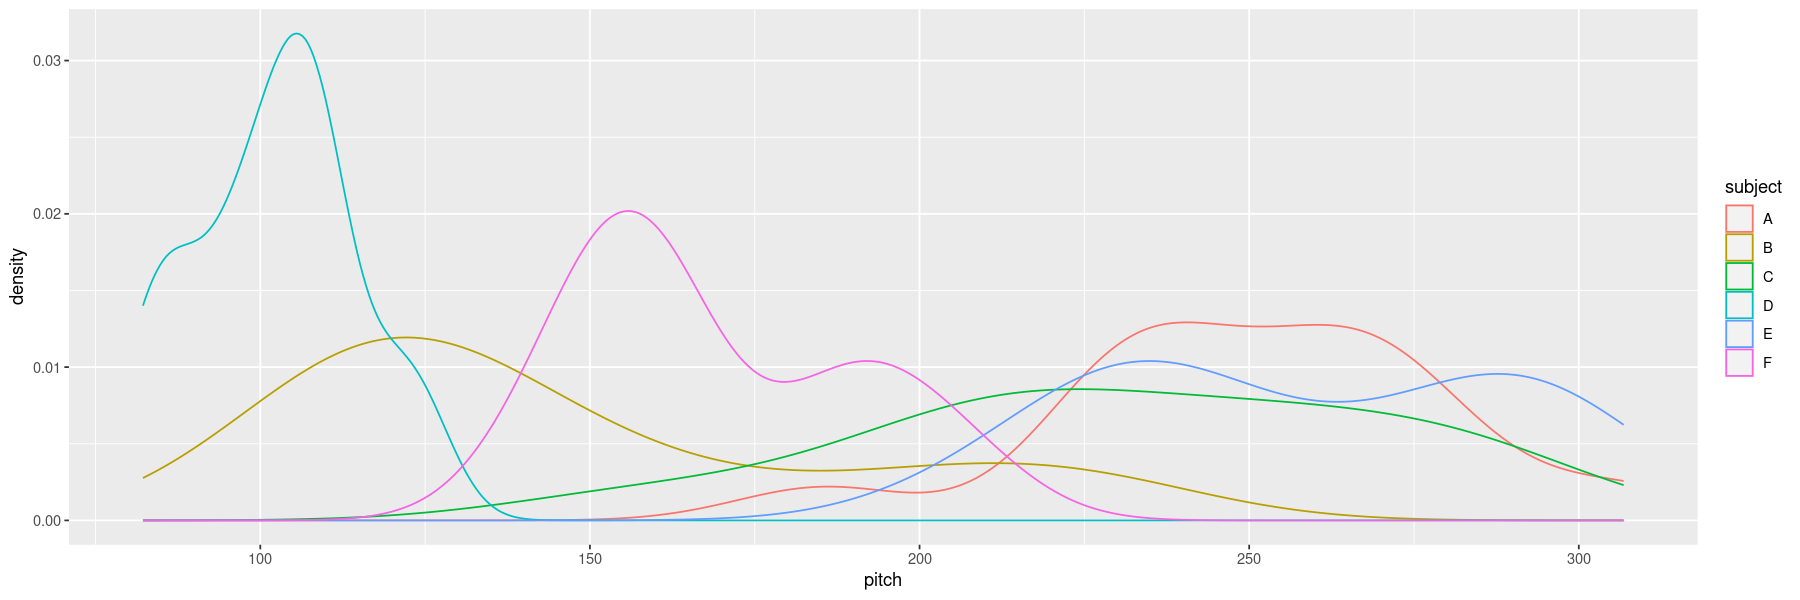

In [35]:
ggplot( voices ) + geom_density( aes(x=pitch, color=subject) )

Box plot:

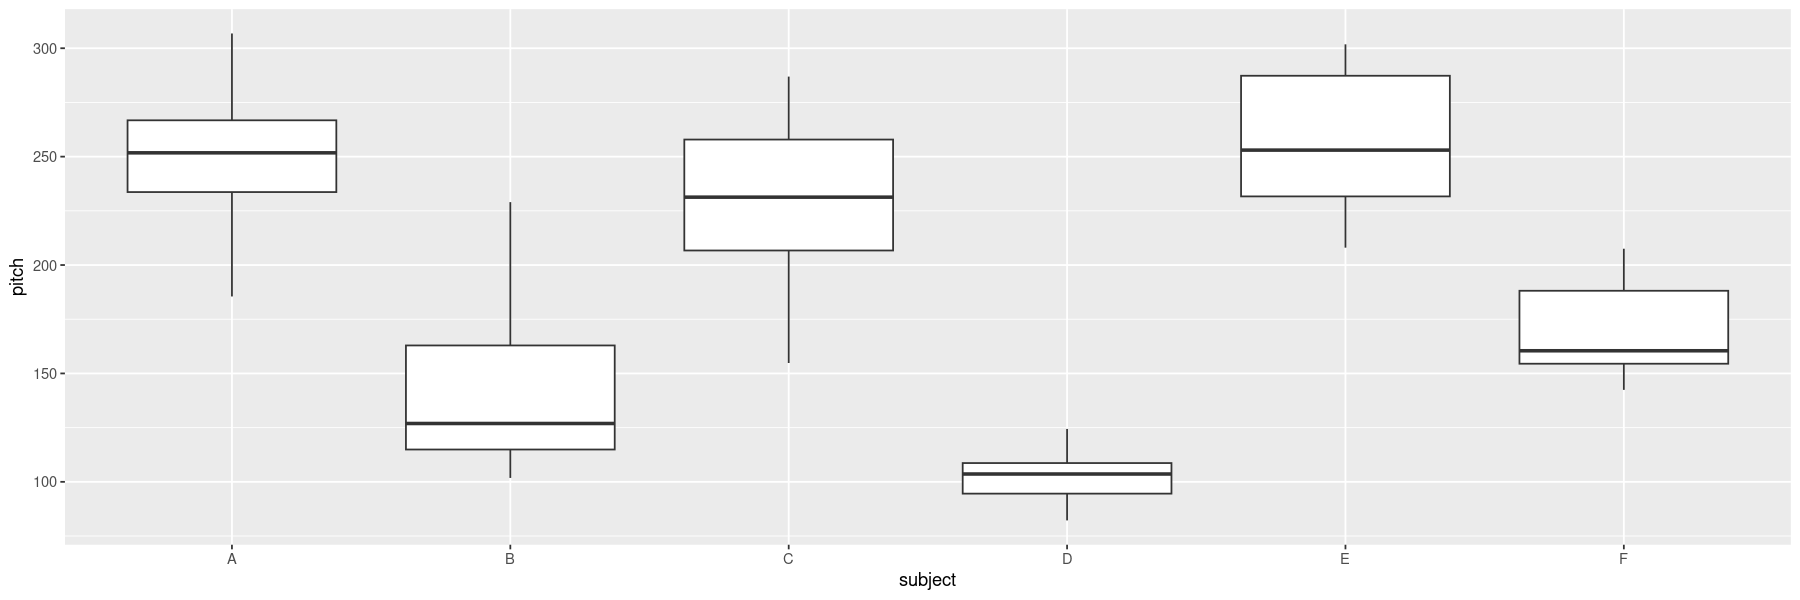

In [36]:
ggplot( voices ) + geom_boxplot( aes(y=pitch, x=subject) )

The within-group variation appears to be smaller than the between-group variation.

### Posterior simulation

In [37]:
voices_hierarchical <- stan_glmer(
  pitch ~ (1 | subject), 
  data = voices, family = gaussian,
  prior_intercept = normal(0, 1, autoscale = TRUE),
  prior_aux = exponential(1, autoscale = TRUE),
  prior_covariance = decov(reg = 1, conc = 1, shape = 1, scale = 1),
  chains = 4, iter = 5000*2, seed = 84735)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 3.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.50277 seconds (Warm-up)
Chain 1:                2.77692 seconds (Sampling)
Chain 1:   

MCMC diagnostics:

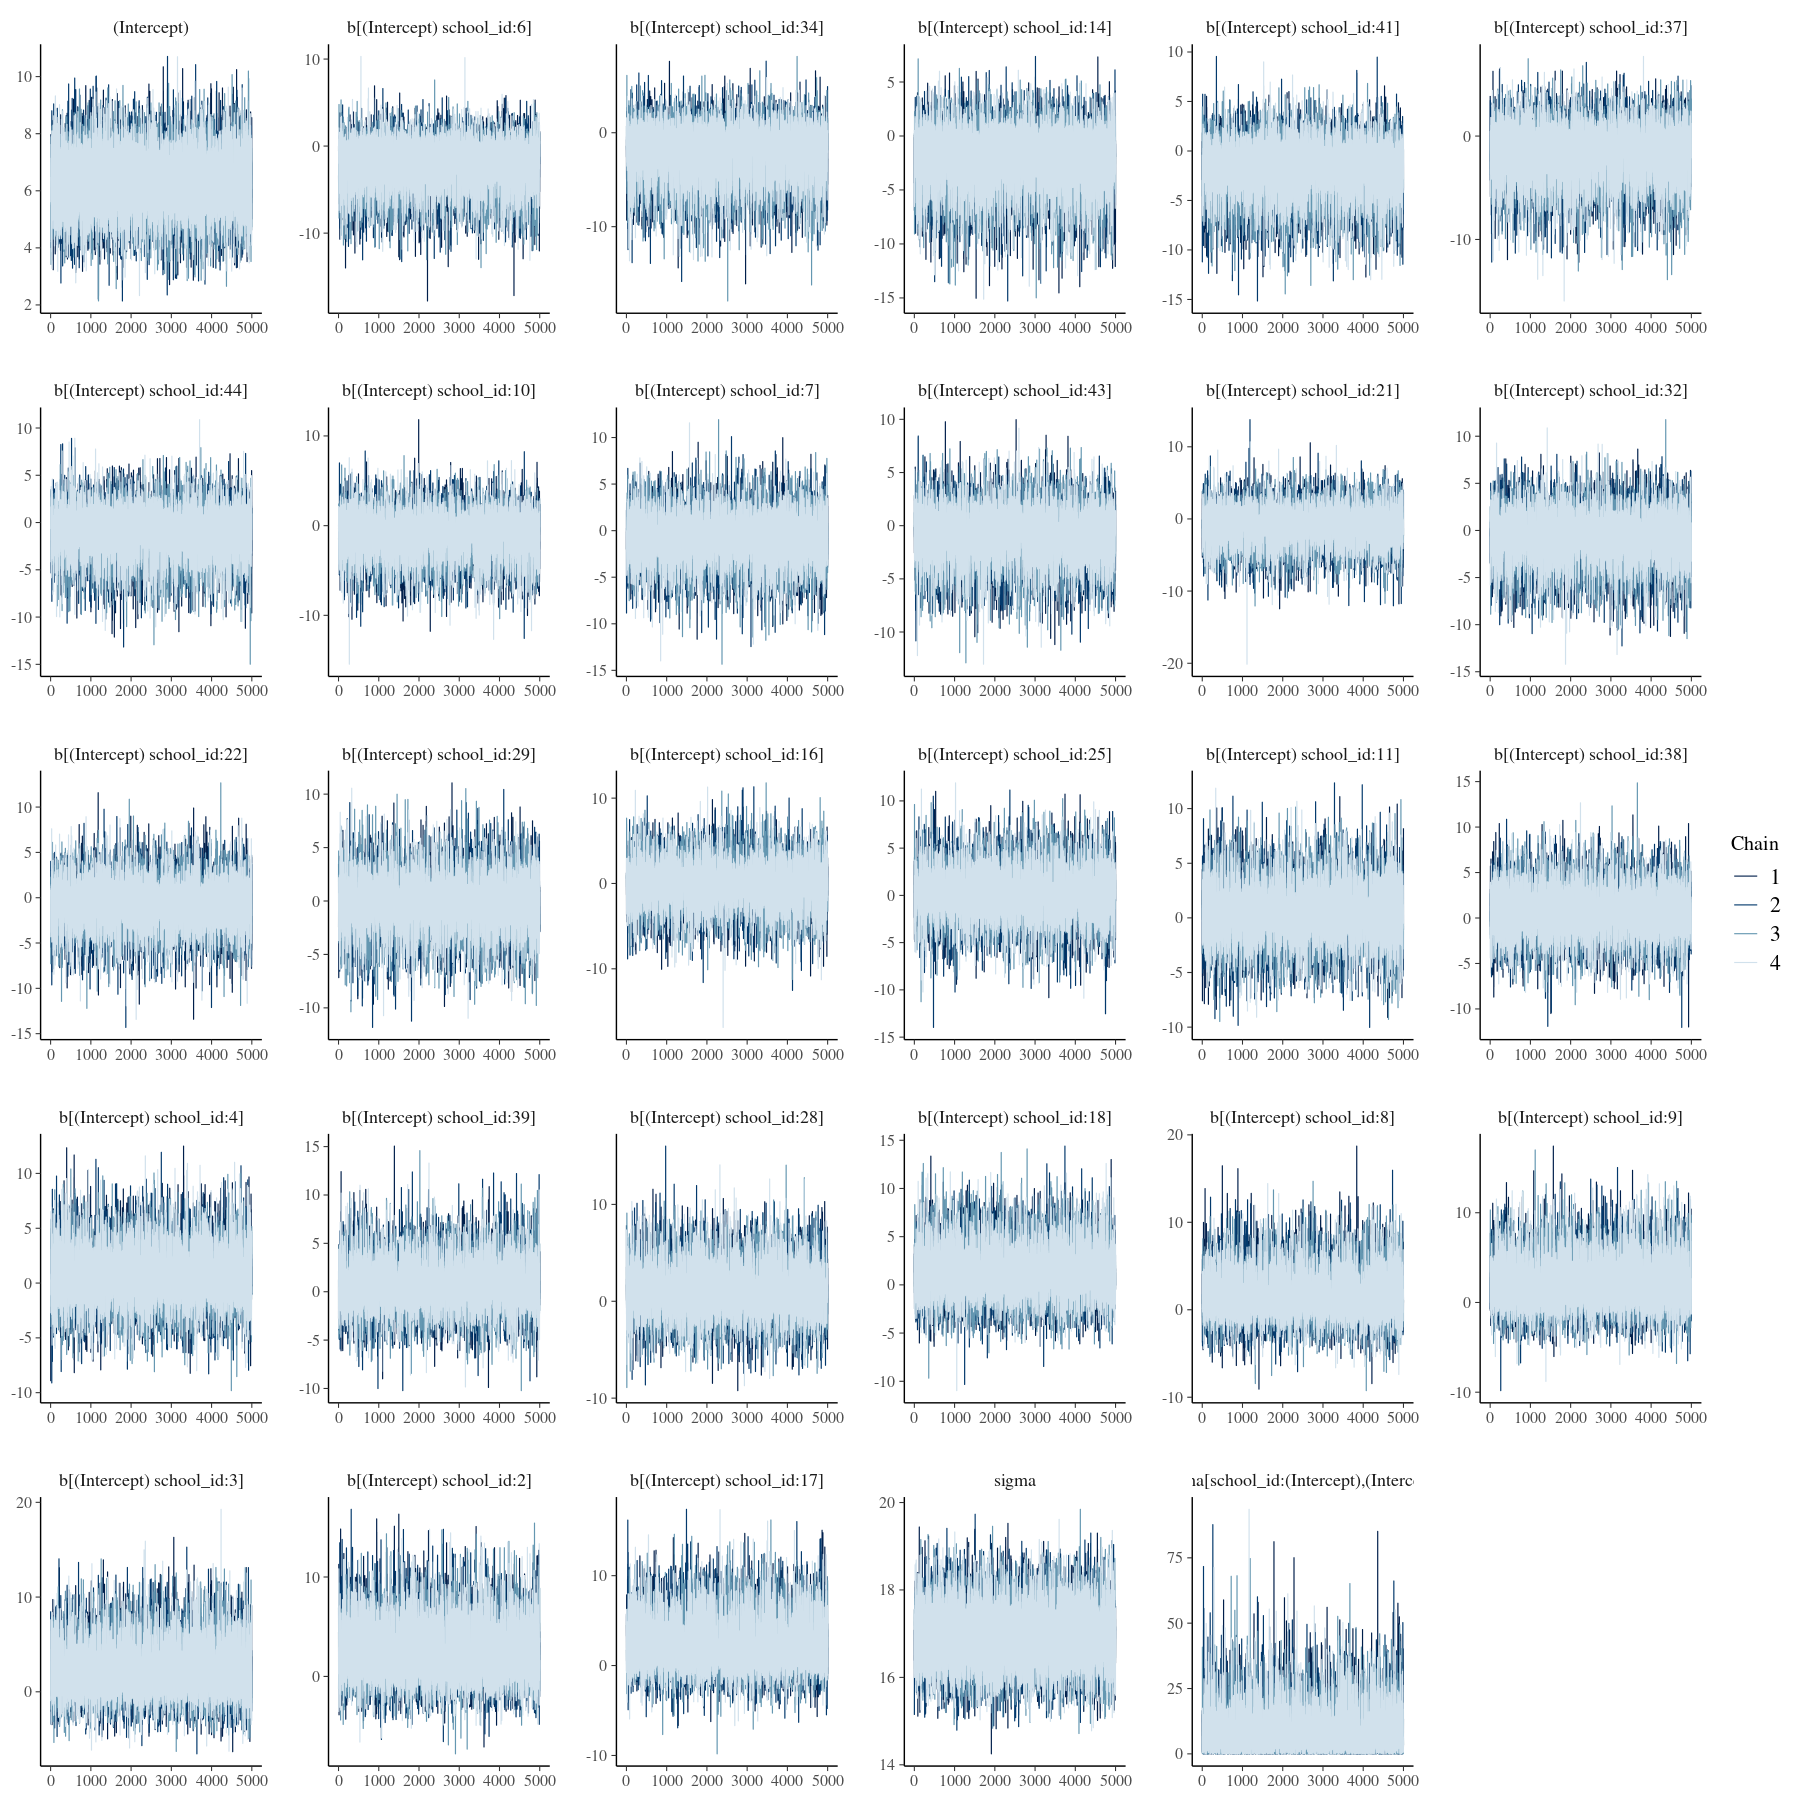

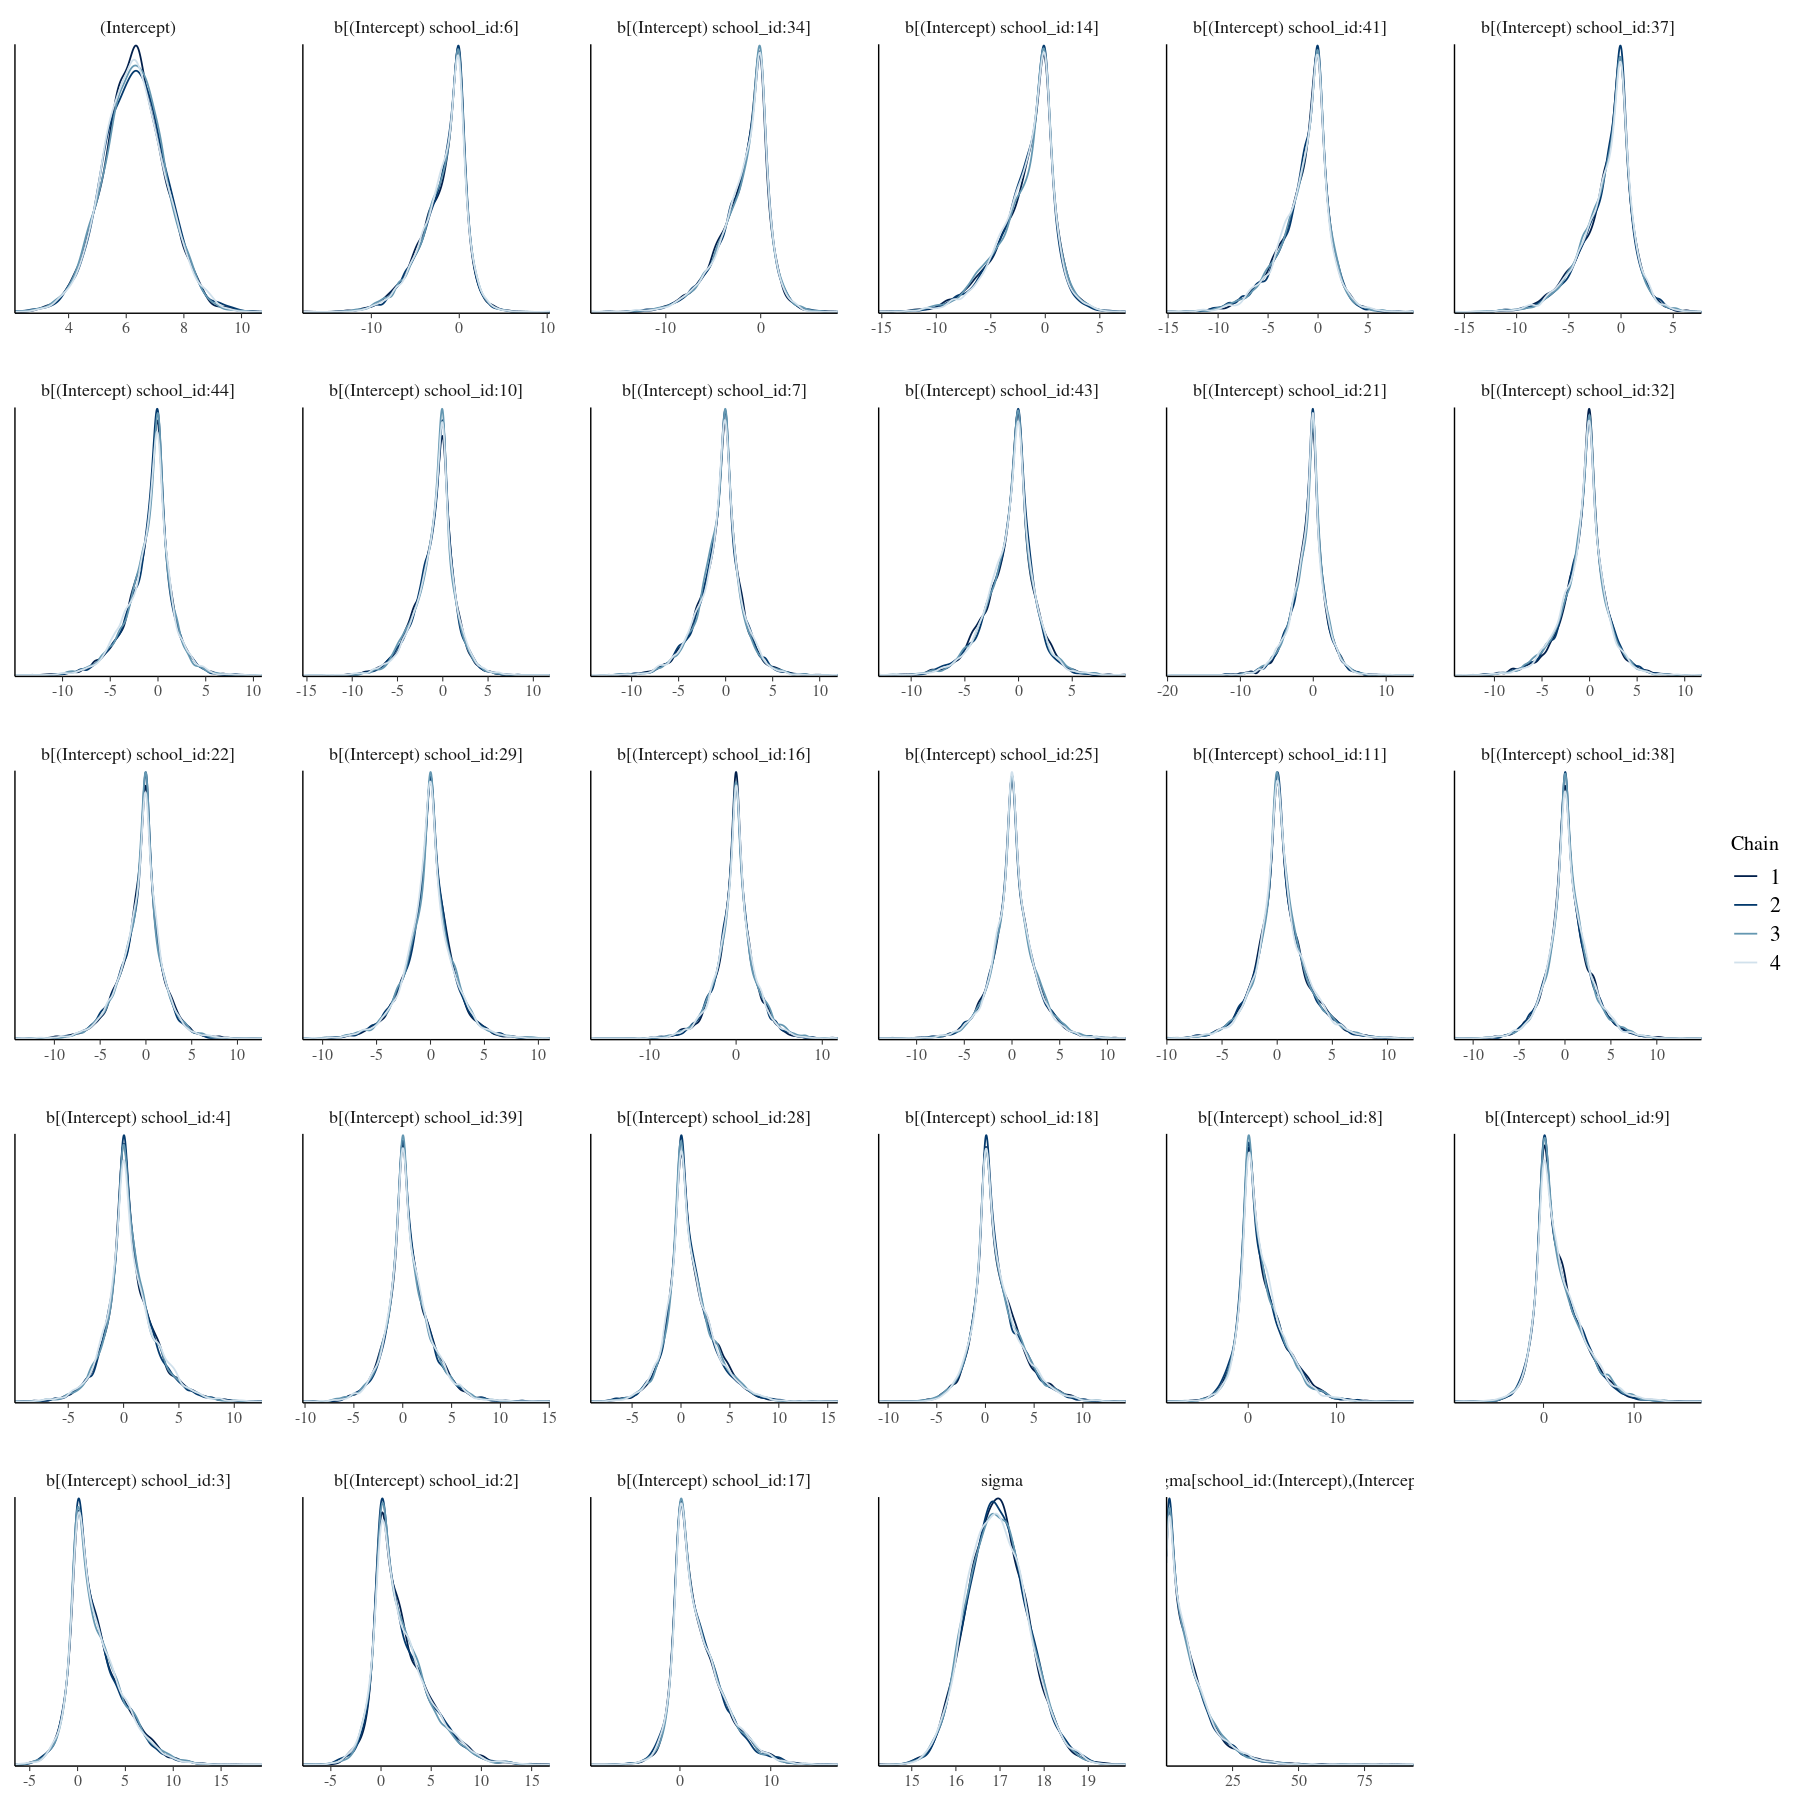

(Intercept) 
                                 0.77660 
              b[(Intercept) school_id:6] 
                                 0.62275 
             b[(Intercept) school_id:34] 
                                 0.64765 
             b[(Intercept) school_id:14] 
                                 0.67435 
             b[(Intercept) school_id:41] 
                                 0.81250 
             b[(Intercept) school_id:37] 
                                 0.78965 
             b[(Intercept) school_id:44] 
                                 0.99500 
             b[(Intercept) school_id:10] 
                                 0.97345 
              b[(Intercept) school_id:7] 
                                 1.11280 
             b[(Intercept) school_id:43] 
                                 0.98760 
             b[(Intercept) school_id:21] 
                                 1.10075 
             b[(Intercept) school_id:32] 
                                 1.06120 
             b[(Intercept) school_id:22] 
                                 1.16885 
             b[(Intercept) school_id:29] 
                                 1.30355 
             b[(Intercept) school_id:16] 
                                 1.24895 
             b[(Intercept) school_id:25] 
                                 1.24195 
             b[(Intercept) school_id:11] 
                                 1.25010 
             b[(Intercept) school_id:38] 
                                 1.21305 
              b[(Intercept) school_id:4] 
                                 1.14410 
             b[(Intercept) school_id:39] 
                                 1.10055 
             b[(Intercept) school_id:28] 
                                 0.98890 
             b[(Intercept) school_id:18] 
                                 0.88975 
              b[(Intercept) school_id:8] 
                                 0.74145 
              b[(Intercept) school_id:9] 
                                 0.70590 
              b[(Intercept) school_id:3] 
                                 0.65550 
              b[(Intercept) school_id:2] 
                                 0.62600 
             b[(Intercept) school_id:17] 
                                 0.59995 
                                   sigma 
                                 1.06340 
Sigma[school_id:(Intercept),(Intercept)] 
                                 0.36505

(Intercept) 
                               0.9999760 
              b[(Intercept) school_id:6] 
                               0.9999884 
             b[(Intercept) school_id:34] 
                               0.9999260 
             b[(Intercept) school_id:14] 
                               0.9999020 
             b[(Intercept) school_id:41] 
                               0.9998495 
             b[(Intercept) school_id:37] 
                               0.9999368 
             b[(Intercept) school_id:44] 
                               0.9999147 
             b[(Intercept) school_id:10] 
                               0.9999079 
              b[(Intercept) school_id:7] 
                               0.9998362 
             b[(Intercept) school_id:43] 
                               0.9999697 
             b[(Intercept) school_id:21] 
                               0.9999895 
             b[(Intercept) school_id:32] 
                               1.0000107 
             b[(Intercept) school_id:22] 
                               0.9999254 
             b[(Intercept) school_id:29] 
                               1.0000545 
             b[(Intercept) school_id:16] 
                               0.9999641 
             b[(Intercept) school_id:25] 
                               1.0000702 
             b[(Intercept) school_id:11] 
                               1.0000969 
             b[(Intercept) school_id:38] 
                               0.9999336 
              b[(Intercept) school_id:4] 
                               0.9998863 
             b[(Intercept) school_id:39] 
                               0.9998744 
             b[(Intercept) school_id:28] 
                               1.0000258 
             b[(Intercept) school_id:18] 
                               1.0000266 
              b[(Intercept) school_id:8] 
                               1.0000867 
              b[(Intercept) school_id:9] 
                               1.0000106 
              b[(Intercept) school_id:3] 
                               0.9999397 
              b[(Intercept) school_id:2] 
                               1.0000568 
             b[(Intercept) school_id:17] 
                               1.0002561 
                                   sigma 
                               0.9998773 
Sigma[school_id:(Intercept),(Intercept)] 
                               1.0001127

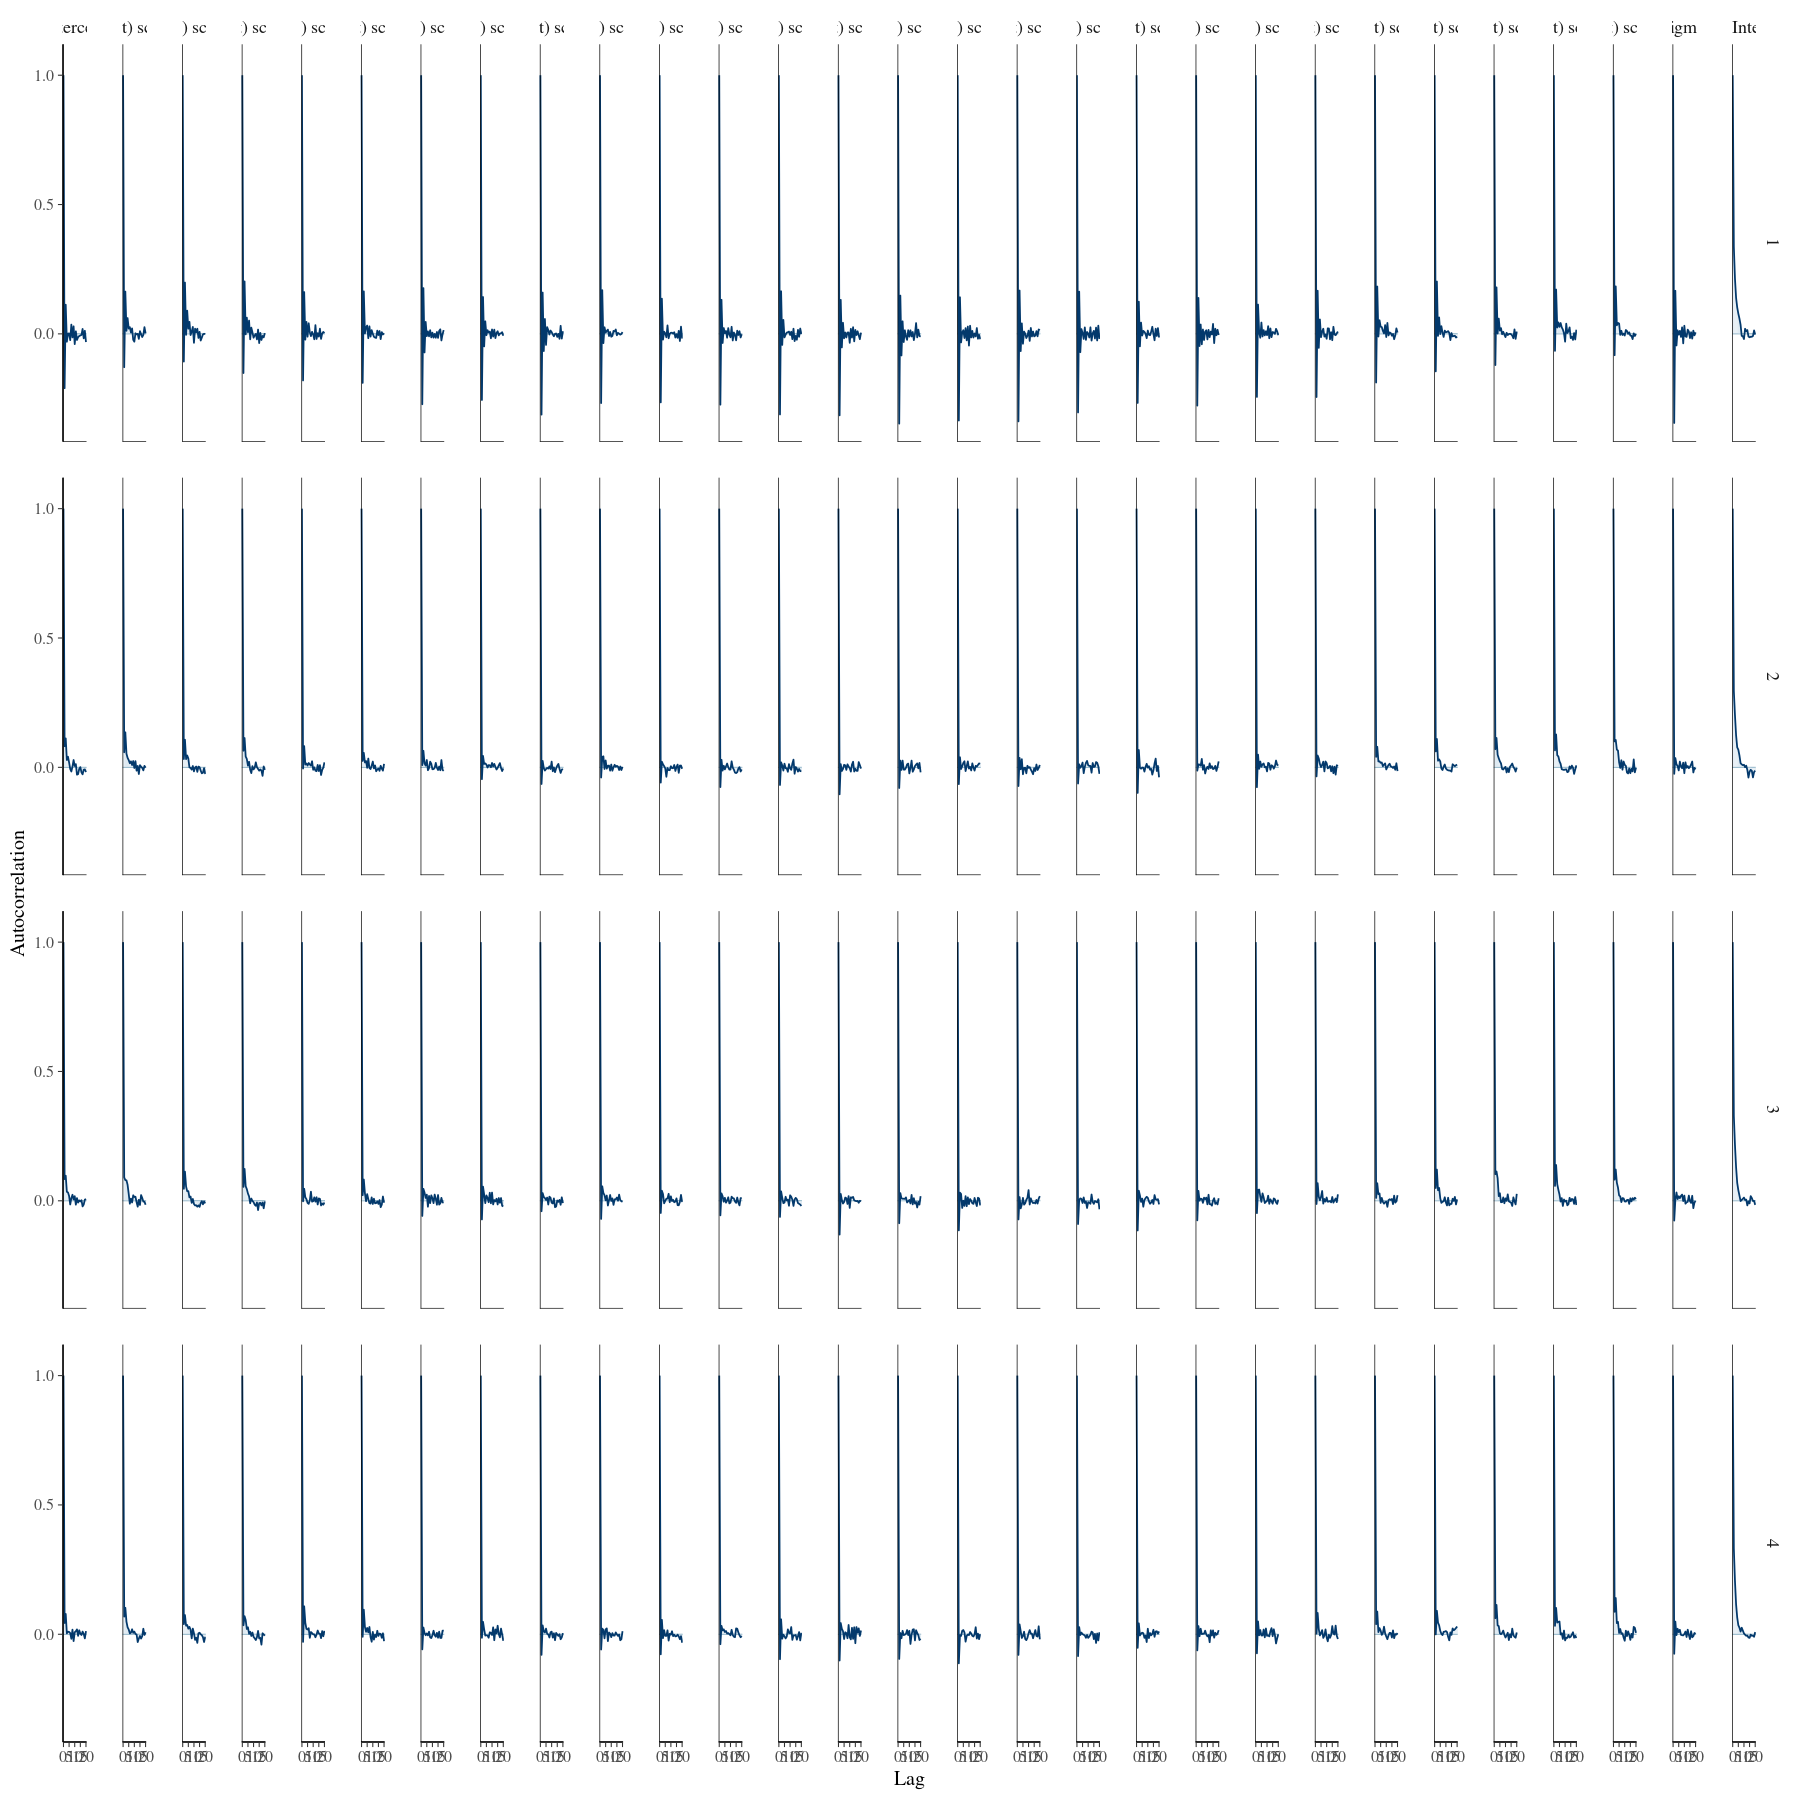

In [38]:
options(repr.plot.width=15, repr.plot.height=15)
mcmc_trace(big_words_hierarchical)
mcmc_dens_overlay(big_words_hierarchical)
mcmc_acf(big_words_hierarchical)
neff_ratio(big_words_hierarchical)
rhat(big_words_hierarchical)

Looks good!

### Posterior predictive check

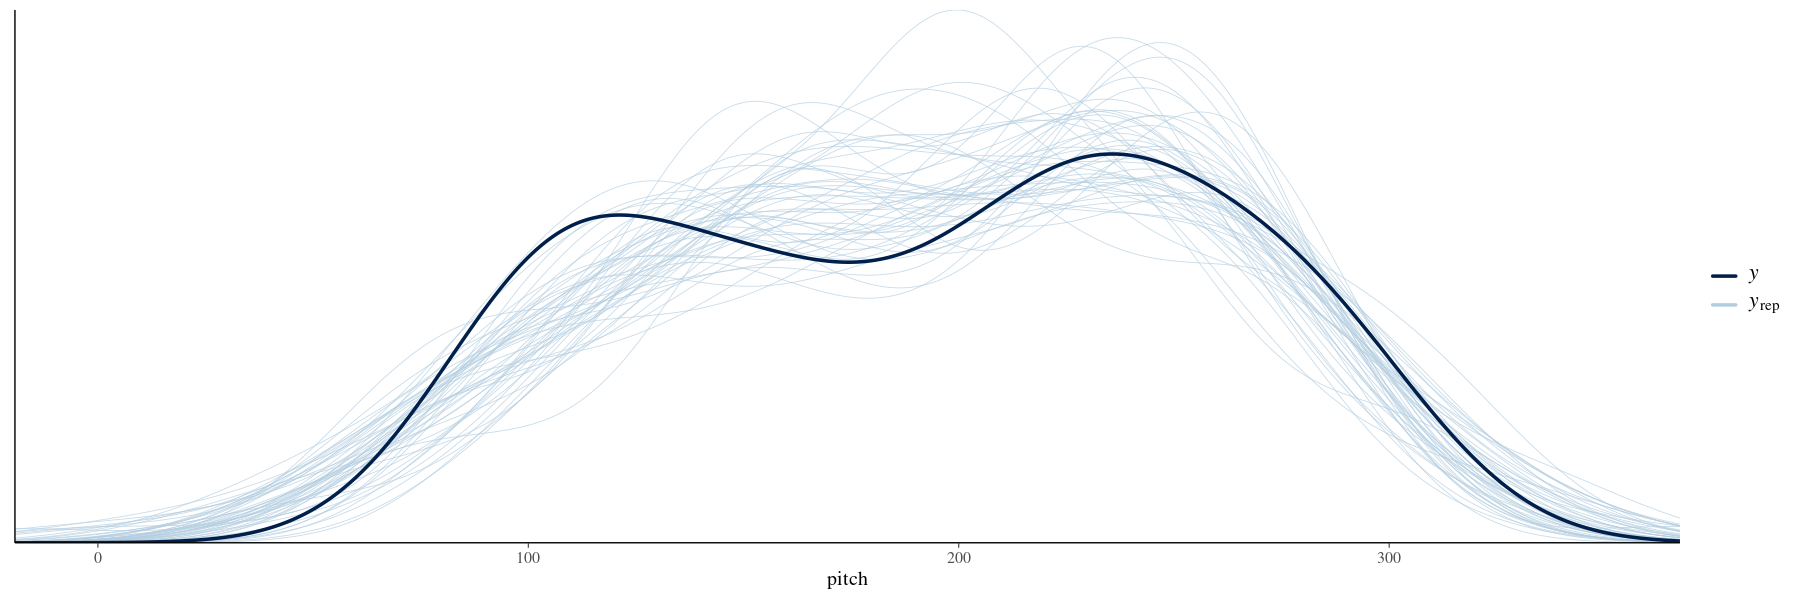

In [39]:
options(repr.plot.width=15, repr.plot.height=5)
pp_check(voices_hierarchical) + xlab("pitch")

Looks very reasonable! Even the bimodality is modeled well.

### Parameter distributions

global mean pitch:

In [40]:
tidy(voices_hierarchical, effects = "fixed", conf.int = TRUE, conf.level = 0.95)

term        estimate std.error conf.low conf.high
1 (Intercept) 165.1566 27.81147  88.14315 212.8491

standard deviations:

In [41]:
sigma_table <- tidy(voices_hierarchical, effects = "ran_pars")
sigma_table

term                    group    estimate
1 sd_(Intercept).subject  subject  73.57285
2 sd_Observation.Residual Residual 31.35868

$\sigma_\mu > \sigma_y$

In [42]:
sigma_mu <- sigma_table$estimate[[1]]
sigma_y <- sigma_table$estimate[[2]]

Part explained by within-group variation:

In [43]:
sigma_y^2 / (sigma_mu^2 + sigma_y^2)

[1] 0.1537392

Part explained by between-group variation:

In [44]:
sigma_mu^2 / (sigma_mu^2 + sigma_y^2)

[1] 0.8462608

In contrast to the previous example, the dominant part is explained by between-group variation, as suspect in exploratory data analysis.

Posterior credible intervals for mean subject pitches:

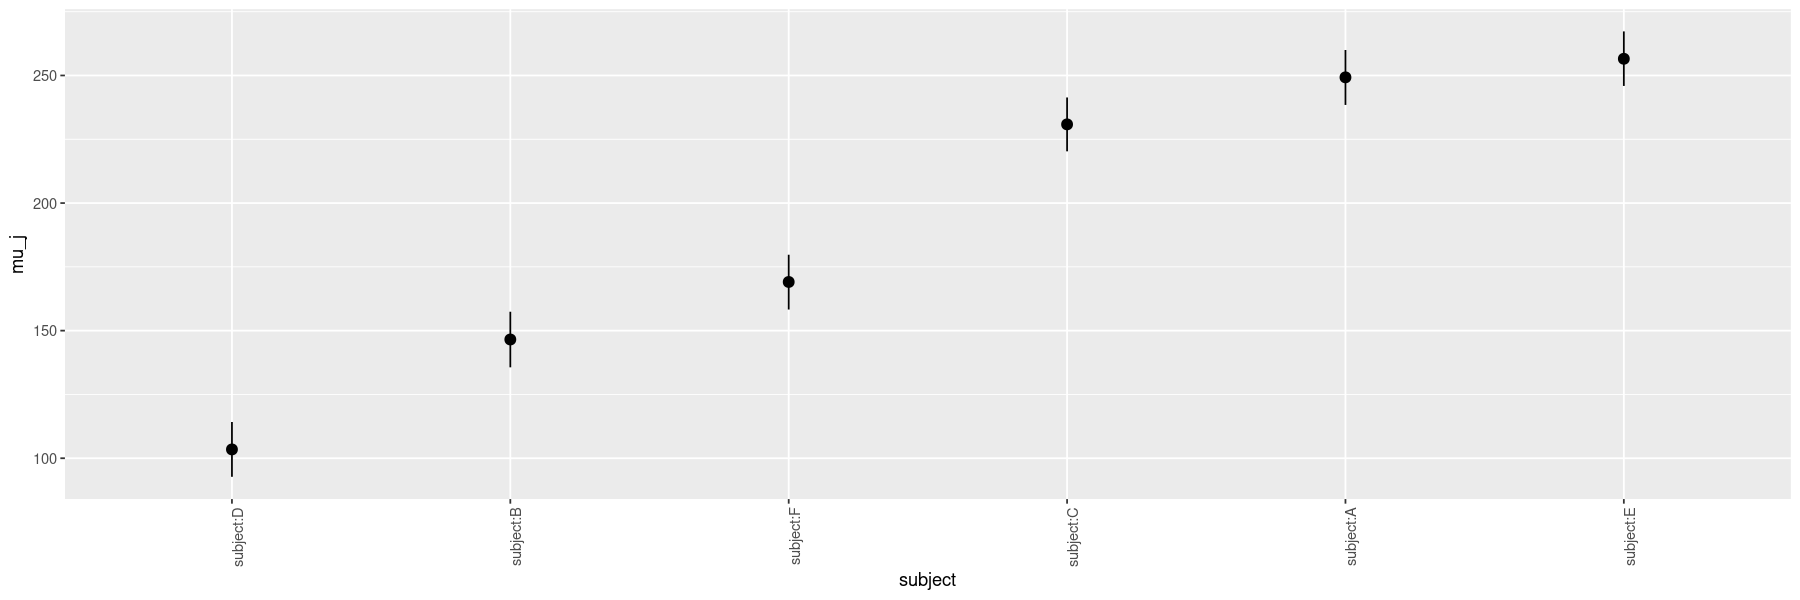

In [45]:
voice_chains <- voices_hierarchical %>%
  spread_draws(`(Intercept)`, b[,subject]) %>% 
  mutate(mu_j = `(Intercept)` + b) 

voice_summary_scaled <- voice_chains %>% 
  select(-`(Intercept)`, -b) %>% 
  mean_qi(.width = 0.80) %>% 
  mutate(subject = fct_reorder(subject, mu_j))

ggplot(voice_summary_scaled, 
       aes(x = subject, y = mu_j, ymin = .lower, ymax = .upper)) +
  geom_pointrange() +
  xaxis_text(angle = 90, hjust = 1)

It is very evident that even though pitches in different situations change, each person retains there characteristic pitch and pitches vary much more between different persons.

### Predictions for all subjects

In [46]:
voice_means <- voices %>% 
  group_by(subject) %>% 
  summarize(count = n(), pitch = mean(pitch))
predictions_hierarchical <- posterior_predict(voices_hierarchical, newdata = voice_means)
head( predictions_hierarchical )

1        2         3        4         5        6       
[1,] 243.0565 166.22962 285.3676 104.80708 251.0994 190.0720
[2,] 270.1476  94.92541 249.8387 111.23562 236.8221 171.5580
[3,] 213.6584 143.08184 138.1591  73.15103 216.6668 234.9504
[4,] 298.2836 158.77370 240.2255 109.94794 208.7477 166.8353
[5,] 333.0936 188.66417 210.2554 134.38662 239.5945 188.5028
[6,] 268.6697 147.59585 265.2764 166.21684 265.2950 164.7258

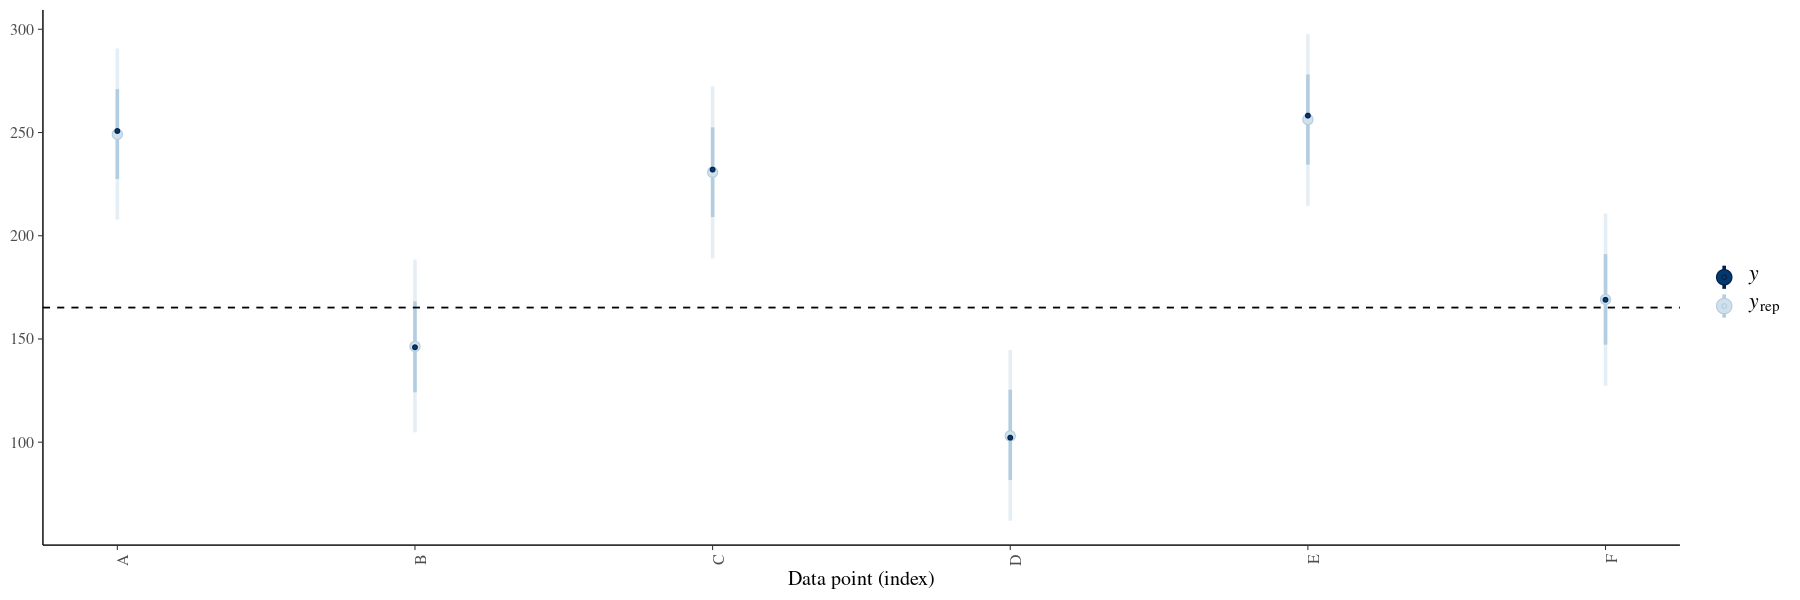

In [47]:
ppc_intervals(voice_means$pitch, yrep = predictions_hierarchical, prob_outer = 0.80) +
  ggplot2::scale_x_continuous(labels = voice_means$subject, breaks = 1:nrow(voice_means)) +
  xaxis_text(angle = 90, hjust = 1) + 
  geom_hline(yintercept = 165.2, linetype = "dashed")

Contrary to Exercise 16.12, now there is almost no shrinkage. Since the between-group variation is much larger than the within-group variation, knowledge of the group explains a lot of the variability in the data.